In [1]:
from HeaderP import *
import Astraea
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice
import random
import time
from tqdm import trange
from stardate.lhf import gk_rotation_model
import stardate
from itertools import product

mpf = 'aviary/data/metal_poor_avr.csv'
mrf = 'aviary/data/metal_rich_avr.csv'
af = 'aviary/data/all_stars_avr.csv'
def get_avr_coefficients():
    """
    Fit the parameters of the AVR using data from Yu & Liu:
    https://arxiv.org/pdf/1712.03965.pdf
    Fit to the relationship between log(sigma_z) and age.
    Returns:
        p_mp (array): coefficients [slope, intercept] for straight line fit to
            metal poor stars.
        p_mr (array): coefficients [slope, intercept] for straight line fit to
            metal rich stars.
        p_a (array): coefficients [slope, intercept] for straight line fit to
            all stars.
    """
    mp = pd.read_csv(mpf)
    mr = pd.read_csv(mrf)
    a = pd.read_csv(af)

    p_mp = np.polyfit(np.log(mp.sigma_z_kms), np.log(mp.Age_Gyr), 1)
    p_mr = np.polyfit(np.log(mr.sigma_z_kms), np.log(mr.Age_Gyr), 1)
    p_a = np.polyfit(np.log(a.sigma_z_kms), np.log(a.Age_Gyr), 1)

    return p_mp, p_mr, p_a

def v_to_age(v, coeffs):
    """
    Convert z velocity dispersion [km/s] to age [Gyr]
    Args:
        v (array): Z Velocity dispersion [km/s].
        coeffs (array): coefficients for straight line fit. [intercept, slope]
    Returns:
        age (array): age in Gyr.
    """
    b, a = coeffs
    logt = np.polyval(coeffs, np.log(v))
    return np.exp(logt)

def genErr(dv, dv_err):
    errorRand=np.random.normal(0, 1, len(dv))
    return dv+dv_err*errorRand


# get average ages
def getAveAges(df,fs,binfs,vz='v_b'):
    min_star=15
    max_star=30
    fslen=len(fs)
    dflen=len(df)
    
    checkpara=np.zeros(fslen)
    paras=np.zeros((dflen,fslen))
    """
    # subtract MS
    z=[ 7.43269812e-21,-2.85871860e-16 ,4.37669326e-12,-3.47574268e-08,1.52548746e-04,
       -3.54673368e-01,3.51882114e+02]
    p = np.poly1d(z)
    for i in range(len(fs)):
        if 'abs_G' in fs[i]:
            df['abs_G_sub']=df['abs_G']-p(df['teff_calc'])
            fs[i]='abs_G_sub'
    """        
            
    for i in range(fslen):
        paras[:,i]=df[fs[i]].values
    
    iso_age=df['iso_age'].values
    iso_age_err=df['iso_age_err1'].values
    
    iso_ave=np.zeros(len(df))
    iso_ave_err=np.zeros(len(df))
    
    vels=df[vz].values
    kin_age=np.zeros(len(df))
            
            
    for i in trange(dflen):
        
        mask=np.ones(dflen, dtype=bool)
        
        for j in range(fslen):
            checkpara[j]=paras[i,j]
            mask = mask & (abs(paras[:,j]-checkpara[j])<binfs[j]/2)
        
        binfs_new=binfs
        while sum(mask)<min_star:
            if any([binfs_new[jj]>2*binfs[jj] for jj in range(len(binfs))]):
                    break
            binfs_new=[i*1.1 for i in binfs_new]
            mask=np.ones(len(df), dtype=bool)
            mask=np.ones(dflen, dtype=bool)
            for j in range(fslen):
                checkpara[j]=paras[i,j]
                mask = mask & (abs(paras[:,j]-checkpara[j])<binfs_new[j]/2)
            
        
        while sum(mask)>max_star:
            if any([binfs_new[jj]<0.2*binfs[jj] for jj in range(len(binfs))]):
                    break
            binfs_new=[i*0.9 for i in binfs_new]
            mask=np.ones(len(df), dtype=bool)
            mask=np.ones(dflen, dtype=bool)
            for j in range(fslen):
                checkpara[j]=paras[i,j]
                mask = mask & (abs(paras[:,j]-checkpara[j])<binfs_new[j]/2)
            
            
        iso_age_single=iso_age[mask]
        iso_age_err_single=iso_age_err[mask]
        
        weights=1/np.power(iso_age_err_single,2)
        iso_ave[i]=sum((iso_age_single*weights)/sum(weights))
        iso_ave_err[i]=np.std(iso_age_err_single)
        
        vels_single=vels[mask]
        
        kin_age[i]=1.5*np.median(abs(vels_single-np.median(vels_single)))
        
        
    p_mp, p_mr, p_a = get_avr_coefficients()
    df['vel_dis']=kin_age
    df['iso_age_ave']=iso_ave
    df['iso_age_ave_err']=iso_ave_err
    return v_to_age(kin_age,p_mr),iso_ave,iso_ave_err

import time
from tqdm import trange
# get average ages
def getkinAges(df,fs,binfs,min_star=5,max_star=30,vz='v_b'):
    countsNo=0
    df=df.reset_index(drop=True)
    fslen=len(fs)
    dflen=len(df)
    
    checkpara=np.zeros(fslen)
    paras=np.zeros((dflen,fslen))
    
    """
    # subtract MS
    z=[ 7.43269812e-21,-2.85871860e-16 ,4.37669326e-12,-3.47574268e-08,1.52548746e-04,
       -3.54673368e-01,3.51882114e+02]
    p = np.poly1d(z)
    for i in range(len(fs)):
        if 'abs_G' in fs[i]:
            df['abs_G_sub']=df['abs_G']-p(df['teff_calc'])
            fs[i]='abs_G_sub'
    """        
            
    for i in range(fslen):
        paras[:,i]=df[fs[i]].values
    
    vels=df[vz].values
    kin_age=np.zeros(len(df))
        

    for i in trange(dflen):
        
        mask=np.ones(dflen, dtype=bool)
        
        for j in range(fslen):
            checkpara[j]=paras[i,j]
            mask = mask & (abs(paras[:,j]-checkpara[j])<binfs[j]/2)
        vels_single=vels[mask]
        
        binfs_new=binfs
        switch=0
        while len(vels_single)<min_star:
            if any([binfs_new[jj]>2*binfs[jj] for jj in range(len(binfs))]):
                    break
            binfs_new=[i*1.1 for i in binfs_new]
            mask=np.ones(len(df), dtype=bool)
            mask=np.ones(dflen, dtype=bool)
            for j in range(fslen):
                checkpara[j]=paras[i,j]
                mask = mask & (abs(paras[:,j]-checkpara[j])<binfs_new[j]/2)
            vels_single=vels[mask]
            switch=1
        if switch==1:
            countsNo=countsNo+1
         
        
        while len(vels_single)>max_star:
            if any([binfs_new[jj]<0.2*binfs[jj] for jj in range(len(binfs))]):
                    break
            binfs_new=[i*0.9 for i in binfs_new]
            mask=np.ones(len(df), dtype=bool)
            mask=np.ones(dflen, dtype=bool)
            for j in range(fslen):
                checkpara[j]=paras[i,j]
                mask = mask & (abs(paras[:,j]-checkpara[j])<binfs_new[j]/2)
            vels_single=vels[mask]
            switch=1
        if switch==1:
            countsNo=countsNo+1
        
                
        kin_age[i]=1.5*np.median(abs(vels_single-np.median(vels_single)))
                
                
    p_mp, p_mr, p_a = get_avr_coefficients()
    df['vel_dis']=kin_age
    df['kin_age']=v_to_age(kin_age,p_mr)
    print(countsNo)
    return kin_age,v_to_age(kin_age,p_mr)
    #print(v_to_age(kin_age,p_mr))
    

# get average ages
def getkinAges_err(df,fs,fs_err,binfs,min_star=5,max_star=30,sampsize=50,vz='v_b',vz_err='v_b_err'):
    # generate new data
    newDatas=np.zeros((len(df),len(fs),sampsize))
    
    ages=np.zeros((len(df),sampsize))
    
    for i in range(len(fs)):
        print(fs[i])
        if 'Prot' in fs[i]:
            newDatas[:,i,:]=np.log10(getErr(df[fs[i]],df[fs_err[i]],sampsize))
        else:
            newDatas[:,i,:]=getErr(df[fs[i]],df[fs_err[i]],sampsize)
    
    # generate new vb data
    newVbs=np.zeros((len(df),sampsize))
    newVbs=getErr(df[vz],df[vz+'_err'],sampsize)
    
    newfs=[i+'_new' for i in fs]
    for i in range(sampsize):
        print(i/sampsize)
        for j in range(len(fs)):
            df[newfs[j]]=newDatas[:,j,i]
        df[vz+'_new']=newVbs[:,i]
        _,ages[:,i]=getkinAges(df,newfs,binfs,vz=vz+'_new',min_star=min_star,max_star=max_star)
    return ages




def getVs(px,pmra,pmdec,ra,dec):
    """ Calculates tangential velocity (v_tan) and vertical velocity proximation (v_b).
    
    Args:
      df ([Pandas DataFrame]): DataFrame contains columns 'parallax', 'pmra', 'pmdec', 'ra', 'dec', which are parallax, ra proper motion, dec propermotion, right ascension and declination, respectively  
    
    Returns:
      :v_t ([array-like]): Tangential velocity
      :v_b ([array-like]): Proxy for vertical velocity
    """
    d = coord.Distance(parallax=np.array(px) * u.mas,allow_negative=True)
    vra = (np.array(pmra)*u.mas/u.yr * d).to(u.km/u.s, u.dimensionless_angles())
    vdec = (np.array(pmdec)*u.mas/u.yr * d).to(u.km/u.s, u.dimensionless_angles())
    v_t=np.sqrt(np.power(vra,2.)+np.power(vdec,2.)) # vtan
    # v_b as a proxy for v_z:
    c = coord.SkyCoord(ra=np.array(ra)*u.deg, dec=np.array(dec)*u.deg, distance=d,
                  pm_ra_cosdec=np.array(pmra)*u.mas/u.yr,
                  pm_dec=np.array(pmdec)*u.mas/u.yr)
    gal = c.galactic
    v_b = (gal.pm_b * gal.distance).to(u.km/u.s, u.dimensionless_angles()) # vb
    return v_t,v_b

def getErr(x,x_errs,numb):
    newX=np.zeros((len(x),numb))
    for i in range(len(x)):
        newX[i,:]=np.random.normal(x[i], x_errs[i], numb)
    return newX

def getDust(G, bp, rp, ebv, maxnit=100):
    """
    Compute the Gaia extinctions assuming relations from Babusieux.
    Author: Sergey Koposov skoposov@cmu.edu
    Args:
        G (float): Gaia G mag.
        bp (float): Gaia BP mag.
        rp (float): Gaia RP mag.
        ebv (float): E(B-V), extinction in B-V.
        maxnit (int): number of iterations
    Returns:
        Extinction in G,bp, rp
    """
    c1, c2, c3, c4, c5, c6, c7 = [0.9761, -0.1704,
                                  0.0086, 0.0011, -0.0438, 0.0013, 0.0099]
    d1, d2, d3, d4, d5, d6, d7 = [
        1.1517, -0.0871, -0.0333, 0.0173, -0.0230, 0.0006, 0.0043]
    e1, e2, e3, e4, e5, e6, e7 = [
        0.6104, -0.0170, -0.0026, -0.0017, -0.0078, 0.00005, 0.0006]
    A0 = 3.1*ebv
    P1 = np.poly1d([c1, c2, c3, c4][::-1])

    def F1(bprp): return np.poly1d(
        [c1, c2, c3, c4][::-1])(bprp)+c5*A0+c6*A0**2+c7*bprp*A0

    def F2(bprp): return np.poly1d(
        [d1, d2, d3, d4][::-1])(bprp)+d5*A0+d6*A0**2+d7*bprp*A0

    def F3(bprp): return np.poly1d(
        [e1, e2, e3, e4][::-1])(bprp)+e5*A0+e6*A0**2+e7*bprp*A0
    xind = np.isfinite(bp+rp+G)
    curbp = bp-rp
    for i in range(maxnit):
        AG = F1(curbp)*A0
        Abp = F2(curbp)*A0
        Arp = F3(curbp)*A0
        curbp1 = bp-rp-Abp+Arp

        delta = np.abs(curbp1-curbp)[xind]
        curbp = curbp1

    AG = F1(curbp)*A0
    Abp = F2(curbp)*A0
    Arp = F3(curbp)*A0
    return AG, Abp, Arp


def bprp_to_teff(bprp):
    """
    Calculate photometric Teff from Gaia color (use dereddened color!)
    Args:
        bprp (array): Gaia G_BP colour minus Gaia G_RP colour.
    Returns:
        teffs (array): Photometric effective temperatures.
    """

    coeffs = [8959.8112335205078, -4801.5566310882568, 1931.4756631851196,
            -2445.9980716705322, 2669.0248055458069, -1324.0671020746231,
            301.13205924630165, -25.923997443169355]
    """
    # Jason's updated parameters:
    coeffs = [-416.585, 39780.0, -84190.5, 85203.9, -48225.9, 15598.5,
              -2694.76, 192.865]
    """

    return np.polyval(coeffs[::-1], bprp)


def bv_to_teff(BV):
    BV=np.array(BV)
    #return np.power(BV+0.4,-2./3.)*5601.
    return 5000.*(np.power(0.92*BV+1.7,-1.)+np.power(0.92*BV+0.62,-1.))

def m_to_M(m, D):
    """
    Convert apparent magnitude to absolute magnitude.
    """
    return m - 5*np.log10(D)-10

def optimizeBins(df,df_match,fs,binmin,binmax,min_star=5,max_star=30,df_match_name='age',df_match_name_err='age_err',vz='v_b',bintestNo=10,errVals=False):

    df=df.dropna(subset=np.append([vz],fs)).reset_index(drop=True)
    p_mp, p_mr, p_a = get_avr_coefficients()
    
    df=df.reset_index(drop=True)
    
    if errVals:
        df_common=pd.merge(df[np.append(['KID','kin_age_err'],fs)],df_match[['KID',df_match_name,df_match_name_err]],left_on='KID',right_on='KID',how='inner')[['KID',df_match_name,df_match_name_err,'kin_age_err']]
        df_common.dropna(subset=['kin_age_err'])
    else:                                                                             
        df_common=pd.merge(df[np.append(['KID'],fs)],df_match,left_on='KID',right_on='KID',how='inner')[['KID',df_match_name,df_match_name_err]]
    
    commonKID=df_common['KID'].values
    
    fslen=len(fs)
    dflen=len(commonKID)
    
    checkpara=np.zeros(fslen)
    paras=np.zeros((len(df),fslen))
    
    """
    # subtract MS
    z=[ 7.43269812e-21,-2.85871860e-16 ,4.37669326e-12,-3.47574268e-08,1.52548746e-04,
       -3.54673368e-01,3.51882114e+02]
    p = np.poly1d(z)
    for i in range(len(fs)):
        if 'abs_G' in fs[i]:
            df['abs_G_sub']=df['abs_G']-p(df['teff_calc'])
            fs[i]='abs_G_sub'
    """    
            
    for i in range(fslen):
        paras[:,i]=df[fs[i]].values
    
    KIDs=df['KID'].values
    
    vels=df[vz].values
    kin_age=np.zeros(len(commonKID))
    No_stars=np.zeros(len(commonKID))
    
    binfs=np.zeros((fslen,bintestNo))
    
    for k in range(fslen):
        binfs[k,:]=np.linspace(binmin[k],binmax[k],bintestNo)
    
    
    testbins=[]
    
    sums=''
    a=['i'+str(i)+',' for i in range(fslen)]
    for i in a:
        sums=sums+i
    
    for a in product(range(bintestNo), repeat=len(a)):
        evalint=[binfs[j,a[j]] for j in range(len(a))]
        #print(evalint)
        testbins.append(evalint)

    
    # optimization
    count=0
    
    for k in trange(len(testbins)):
        binfs=testbins[k]
        for i in range(len(commonKID)):
            ind=np.where(KIDs==commonKID[i])

            mask=np.ones(len(df), dtype=bool)
        
            for j in range(fslen):
                checkpara[j]=paras[ind,j]
                mask = mask & (abs(paras[:,j]-checkpara[j])<binfs[j]/2.)
            vels_single=vels[mask]
            
            binfs_new=binfs
        
            
            while len(vels_single)<min_star:
                if any([binfs_new[jj]>2*binfs[jj] for jj in range(len(binfs))]):
                    break
                #print([binfs_new[jj]>1.5*binfs[jj] for jj in range(len(binfs))])
                binfs_new=[ii*1.1 for ii in binfs_new]
                mask=np.ones(len(df), dtype=bool)
                for j in range(fslen):
                    checkpara[j]=paras[ind,j]
                    mask = mask & (abs(paras[:,j]-checkpara[j])<binfs_new[j]/2)
                vels_single=vels[mask]
                
            while len(vels_single)>max_star:
                if any([binfs_new[jj]<0.2*binfs[jj] for jj in range(len(binfs))]):
                    break
                binfs_new=[ii*0.9 for ii in binfs_new]
                mask=np.ones(len(df), dtype=bool)
                for j in range(fslen):
                    checkpara[j]=paras[ind,j]
                    mask = mask & (abs(paras[:,j]-checkpara[j])<binfs_new[j]/2)
                vels_single=vels[mask]
            
            kin_age[i]=1.5*np.median(abs(vels_single-np.median(vels_single)))
            No_stars[i]=len(vels_single)
        
        df_common['veldisp']=kin_age
        df_common['kin_age']=v_to_age(df_common['veldisp'],p_mr)
        
        if errVals:
            df_test=df_common.dropna(subset=['veldisp','kin_age','kin_age_err'])
        else:
            df_test=df_common.dropna(subset=['veldisp','kin_age'])
        
        if len(df_test)==0:
            continue 
        
        if count==0:
            if errVals:
                print(df_test)
                sigma=df_test[df_match_name_err]**2+df_test['kin_age_err']**2
                chisq=sum(((df_test[df_match_name]-df_test['kin_age'])**2./sigma))/len(df_test)
            else:
                chisq=sum(((df_test[df_match_name]-df_test['kin_age'])**2./np.power(df_test[df_match_name_err],2.)))/len(df_test)
            df_best=df_test
            opt_binsize=binfs
            count=count+1
        else:
            if errVals:
                sigma=df_test[df_match_name_err]**2+df_test['kin_age_err']**2
                chisq_new=sum(((df_test[df_match_name]-df_test['kin_age'])**2./sigma))/len(df_test)
            else:        
                chisq_new=sum(((df_test[df_match_name]-df_test['kin_age'])**2./np.power(df_test[df_match_name_err],2.)))/len(df_test)
            if chisq_new<chisq:
                opt_binsize=binfs
                chisq=chisq_new
                df_best=df_test
            count=count+1
        
    print(opt_binsize)
    
    checkpara=np.zeros(fslen)
    
    for i in trange(len(commonKID)):
        ind=np.where(KIDs==commonKID[i])

        mask=np.ones(len(df), dtype=bool)
        """
        # subtract MS
        z=[ 7.43269812e-21,-2.85871860e-16 ,4.37669326e-12,-3.47574268e-08,1.52548746e-04,
           -3.54673368e-01,3.51882114e+02]
        p = np.poly1d(z)
        
        for i in range(len(fs)):
            if 'abs_G' in fs[i]:
                df['abs_G_sub']=df['abs_G']-p(df['teff_calc'])
                fs[i]='abs_G_sub'
        """    
        for j in range(fslen):
            checkpara[j]=paras[ind,j]
            mask = mask & (abs(paras[:,j]-checkpara[j])<opt_binsize[j]/2)

        vels_single=vels[mask]
        binfs_new=opt_binsize
            
            
        while len(vels_single)<min_star:
            if any([binfs_new[jj]>2*opt_binsize[jj] for jj in range(len(opt_binsize))]):
                break
            binfs_new=[ii*1.1 for ii in binfs_new]
            mask=np.ones(len(df), dtype=bool)
            for j in range(fslen):
                checkpara[j]=paras[ind,j]
                mask = mask & (abs(paras[:,j]-checkpara[j])<binfs_new[j]/2)
            vels_single=vels[mask]
            #print(len(vels_single),binfs_new)
            
        while len(vels_single)>max_star:
            if any([binfs_new[jj]<0.2*opt_binsize[jj] for jj in range(len(opt_binsize))]):
                break
            binfs_new=[ii*0.9 for ii in binfs_new]
            mask=np.ones(len(df), dtype=bool)
            for j in range(fslen):
                checkpara[j]=paras[ind,j]
                mask = mask & (abs(paras[:,j]-checkpara[j])<binfs_new[j]/2)
            vels_single=vels[mask]
            
        vels_single=vels[mask]
        kin_age[i]=1.5*np.median(abs(vels_single-np.median(vels_single)))
        No_stars[i]=len(vels_single)
            
    df_common['kin_age']=v_to_age(kin_age,p_mr)
    df_common['NumbStars']=No_stars
    df_common['measure_age']=df_common[df_match_name]
    df_common['measure_age_err']=df_common[df_match_name_err]
    
    print(df_common['kin_age']-df_best['kin_age'])
    
    if errVals:
        df_common['kin_age_err']=df_common['kin_age_err']
        return opt_binsize, df_common[['KID','kin_age','kin_age_err','measure_age','measure_age_err','NumbStars']],chisq
    else:
        return opt_binsize, df_common[['KID','kin_age','measure_age','measure_age_err','NumbStars']],chisq



def GetParaErrors(df,samp=1000):
    vts=np.zeros((len(df),samp))
    vbs=np.zeros((len(df),samp))
    px_s=getErr(df['parallax'].values,df['parallax_error'].values,samp)
    pmra_s=getErr(df['pmra'].values,df['pmra_error'].values,samp)
    pmdec_s=getErr(df['pmdec'].values,df['pmdec_error'].values,samp)
    ra_s=getErr(df['ra'].values,df['ra_error'].values,samp)
    dec_s=getErr(df['dec'].values,df['dec_error'].values,samp)
    for i in trange(samp):
        vts[:,i],vbs[:,i]=getVs(px_s[:,i],pmra_s[:,i],pmdec_s[:,i],ra_s[:,i],dec_s[:,i])
    
    vt_err=np.zeros(len(df))
    vb_err=np.zeros(len(df))

    for i in trange(len(df)):
        vt_err[i]=np.std(vts[i,:])
        vb_err[i]=np.std(vbs[i,:])  
    
    df['v_t_err']=vt_err
    df['v_b_err']=vb_err

    absg_err=np.zeros((len(df),samp))

    px_s=getErr(df['parallax'].values,df['parallax_error'].values,samp)
    
    for i in trange(samp):
        absg_err[:,i]=m_to_M(df.phot_g_mean_mag.values, 1./px_s[:,i])


    absg_err_err=np.zeros(len(df))
    for i in trange(len(df)):
        absg_err_err[i]=np.std(absg_err[i,:])
    df['abs_G_err']=absg_err_err

    Ro_err=np.zeros((len(df),samp))
    mass_s=getErr(df['mass'].values,df['mass_err1'].values,samp)
    Prot_s=getErr(df['Prot'].values,df['Prot_err'].values,samp)
    
    for i in trange(samp):
        Ro_err[:,i]=Prot_s[:,0]/stardate.convective_overturn_time(mass_s[:,i])

    Ro_err_err=np.zeros(len(df))
    for i in trange(len(df)):
        Ro_err_err[i]=np.std(Ro_err[i,:])
    df['Ro_err']=Ro_err_err
    
    return df


def findstars(df,f1_star,f2_star,f3_star,f1='color_teffs',f2='Prot',f3='abs_G'):
    KIDs=np.zeros(len(f1_star))
    count=0
    for i in range(len(f1_star)):
        update_progress(i/len(f1_star))
        teff,prot,abs_g=f1_star[i],f2_star[i],f3_star[i]
        df['dist']=np.power(df[f1]-teff,2.)+np.power(df[f2]-prot,2.)+np.power(df[f3]-prot,2.)
        KIDs[count]=df.sort_values(by=['dist'])['KID'].iloc[0]
        count=count+1
    return KIDs


def countstars(df,fs,binfs):
    df=df.reset_index(drop=True)
    fslen=len(fs)
    dflen=len(df)
    
    checkpara=np.zeros(fslen)
    paras=np.zeros((dflen,fslen))
    for i in range(fslen):
        paras[:,i]=df[fs[i]].values
    
    starNo=np.zeros(len(df))
    
    for i in trange(dflen):
        
        mask=np.ones(dflen, dtype=bool)
        
        for j in range(fslen):
            checkpara[j]=paras[i,j]
            mask = mask & (abs(paras[:,j]-checkpara[j])<binfs[j]/2)
        
        starNo[i]=sum(mask)
    return starNo
        
    
def calcChi2(x,y,xerr,yerr):
    return sum(np.power(x-y,2)/(xerr**2.+yerr**2.)/len(x))

/Users/lucy/anaconda3/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence
/Users/lucy/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:18: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable
/Users/lucy/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:16: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping, namedtuple, defaultdict, Sequence
/Users/lucy/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module 

In [2]:
df=pd.read_pickle('clusters.pkl')
list(df.columns)

['CLUSTER',
 'DR2NAME',
 'DR2_NUM',
 'ID',
 'ID_SOURCE',
 'RA',
 'DEC',
 'BP_RP',
 'GMAG',
 'AGE',
 'AV',
 'PLX',
 'DISTANCE',
 'DM',
 'BP_RP_0',
 'M_G',
 'BINARY_SHORT',
 'BINARY_WIDE',
 'PROT',
 'E_PROT',
 'PROT_REF',
 'TEFF',
 'MASS',
 'BENCH',
 'KID',
 'AGE_err']

In [3]:
p_mr

NameError: name 'p_mr' is not defined

In [ ]:
print(len(pd.read_pickle('KinageAllKepler_cut.pkl')))
print(len(pd.read_pickle('Kinages_Prot.pkl')))



In [ ]:
154988-30127

# For stars with Prot

In [6]:
df_ruth=pd.read_table('all_rvs.csv',delimiter=',')

/Users/lucy/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (5,6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
35328-29949

5379

In [3]:
#df_ruth=pd.read_table('all_rvs.csv',delimiter=',')
df_ruth=pd.read_pickle('Kinages_Prot.pkl')
df_ruth

KIC_x  iso_mass  iso_mass_err1  iso_mass_err2  iso_teff  \
0        757099     0.873          0.054         -0.039    5364.9   
1        892713     1.731          0.219         -0.087    6238.9   
2        892834     0.751          0.034         -0.039    4823.2   
3        893033     0.685          0.027         -0.030    4707.6   
4        893165     1.152          0.073         -0.092    5989.1   
...         ...       ...            ...            ...       ...   
30122  12934465     0.750          0.036         -0.036    4769.3   
30123  12934525     0.829          0.041         -0.054    5264.3   
30124  12934557     1.298          0.062         -0.074    5619.0   
30125  12934814     0.480          0.012         -0.012    3690.7   
30126  12984138     0.811          0.048         -0.039    5052.3   

       iso_teff_err1  iso_teff_err2  iso_logg  iso_logg_err1  iso_logg_err2  \
0              102.7          -84.9     4.318          0.037         -0.029   
1              123.4         -129.8     3.548          0.066         -0.037   
2               90.4          -82.2     4.587          0.023         -0.028   
3               87.6          -82.5     4.636          0.018         -0.023   
4              115.7         -102.5     4.154          0.038         -0.042   
...              ...            ...       ...            ...            ...   
30122           83.6          -76.0     4.579          0.026         -0.027   
30123           95.3          -90.7     4.555          0.026         -0.039   
30124          123.5         -117.8     3.747          0.034         -0.036   
30125           79.1          -68.9     4.739          0.012         -0.012   
30126           90.3          -82.6     4.501          0.041         -0.034   

       ...  all_vz_new        v_t        v_b  kin_age_err  nostars  \
0      ...   -3.524411   6.947554  -6.672655     1.480028      2.0   
1      ...  -11.557931  50.609179 -20.039490     1.534096      2.0   
2      ...   -4.240750  16.909004  -0.966857     1.057819     59.0   
3      ...  -42.466819  48.426129 -47.684635     1.873166     40.0   
4      ...    5.157617  12.760849   0.474581     4.777703      1.0   
...    ...         ...        ...        ...          ...      ...   
30122  ...   11.341051  64.961322   8.648168     1.561250     53.0   
30123  ...   11.165400  59.579629  -1.165221     1.366047     99.0   
30124  ...   -8.220694  55.405537  -9.301745     2.345089      2.0   
30125  ...   30.579774  23.521680  23.200026     2.183354     14.0   
30126  ...    0.041339   3.918576  -0.407244     0.681916     58.0   

         teff_calc   vz_err  vz_err_all  Prot_new  kin_age_err_AVR  
0      5285.025302      NaN    3.402735 -0.447762         1.820716  
1      6308.395861  0.79035    0.790350  0.728986         2.180830  
2      4881.242378      NaN    3.273900  1.139536         0.455820  
3      4689.994994      NaN    3.357002  1.430803         3.458726  
4      5933.168611      NaN    3.284599  1.773420         1.942309  
...            ...      ...         ...       ...              ...  
30122  4750.924050      NaN    5.280710  1.545089         3.769805  
30123  5282.823374      NaN    5.304149  1.396927         1.458143  
30124  5674.284026      NaN    5.360217  1.489325         3.038296  
30125  3570.686523      NaN    5.304116  1.666386         2.235324  
30126  5068.266081      NaN    5.383576  1.081337         1.280733  

[29949 rows x 258 columns]

In [10]:
max(df_ruth.color_teffs)

7969.543271177007

In [11]:
LAMOST=pd.read_pickle('Kepler_LAMOST.pkl')
print(LAMOST['radial_velocity'])

10      -28.191136
12             NaN
14             NaN
15             NaN
18             NaN
           ...    
56940          NaN
56942          NaN
56945          NaN
56952          NaN
56955          NaN
Name: radial_velocity, Length: 12875, dtype: float64


In [12]:
list(LAMOST.columns)

['KIC',
 'iso_mass',
 'iso_mass_err1',
 'iso_mass_err2',
 'iso_teff',
 'iso_teff_err1',
 'iso_teff_err2',
 'iso_logg',
 'iso_logg_err1',
 'iso_logg_err2',
 'iso_feh',
 'iso_feh_err1',
 'iso_feh_err2',
 'iso_rad',
 'iso_rad_err1',
 'iso_rad_err2',
 'iso_rho',
 'iso_rho_err1',
 'iso_rho_err2',
 'iso_lum',
 'iso_lum_err1',
 'iso_lum_err2',
 'iso_age',
 'unReAgeFlag',
 'iso_age_err1',
 'iso_age_err2',
 'iso_dis',
 'iso_dis_err1',
 'iso_dis_err2',
 'iso_avs',
 'iso_gof',
 'TAMS\\\\',
 'solution_id',
 'designation',
 'source_id',
 'random_index',
 'gaia_ref_epoch',
 'ra',
 'ra_error',
 'dec',
 'dec_error',
 'parallax',
 'parallax_error',
 'parallax_over_error',
 'pmra',
 'pmra_error',
 'pmdec',
 'pmdec_error',
 'ra_dec_corr',
 'ra_parallax_corr',
 'ra_pmra_corr',
 'ra_pmdec_corr',
 'dec_parallax_corr',
 'dec_pmra_corr',
 'dec_pmdec_corr',
 'parallax_pmra_corr',
 'parallax_pmdec_corr',
 'pmra_pmdec_corr',
 'astrometric_n_obs_al',
 'astrometric_n_obs_ac',
 'astrometric_n_good_obs_al',
 'astrom

(3000, 7000)

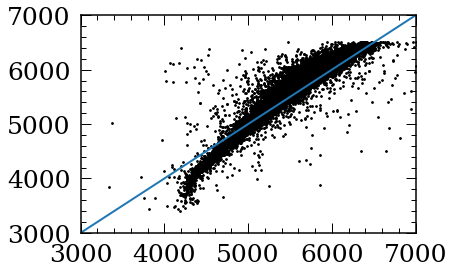

In [18]:
plt.scatter(LAMOST['Teff'],LAMOST['teff_calc'],c='k',s=3)
plt.plot([0,8000],[0,8000])
plt.xlim([3000,7000])
plt.ylim([3000,7000])

In [29]:
len(LAMOST)

12875

(7000, 3000)

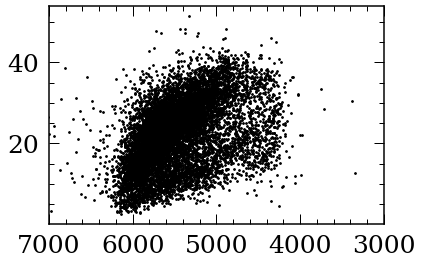

In [27]:
plt.scatter(LAMOST['Teff'],LAMOST['Prot_predict'],c='k',s=3)
plt.xlim([7000,3000])


(7000, 3000)

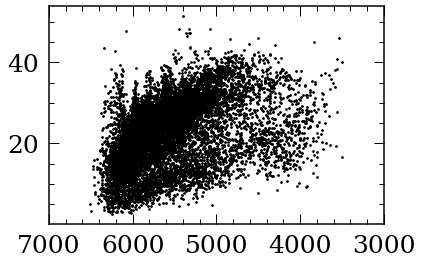

In [28]:
plt.scatter(LAMOST['teff_calc'],LAMOST['Prot_predict'],c='k',s=3)
plt.xlim([7000,3000])

In [29]:
df_ruth['all_vz_err']=df_ruth.vz_inferred_err

In [30]:
vzerr=df_ruth['all_vz_err'].values
vberr=df_ruth['v_b_err'].values
for i in range(len(vzerr)):
    if np.isnan(vzerr[i]):
        vzerr[i]=vberr[i]

In [32]:
df_ruth['all_vz_err']=vzerr

In [8]:
#df_ruth.to_pickle('df_ruth.pkl')
df_ruth=pd.read_pickle('df_ruth.pkl')

In [20]:
df_ruth=df_ruth.loc[df_ruth['Prot_err']<10]
df_ruth=df_ruth.loc[df_ruth['teff_err1']<500]
df_ruth=df_ruth.loc[df_ruth['Ro_err']<1]
df_ruth=df_ruth.reset_index(drop=True)

31025


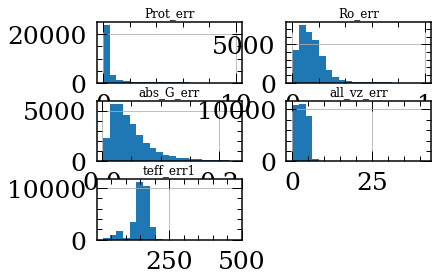

In [30]:
df_ruth[['Prot_err','teff_err1','abs_G_err','Ro_err','all_vz_err']].hist(bins=20)
print(len(df_ruth))

In [22]:
df_ruth=df_ruth.reset_index(drop=True)

In [23]:
# calculate errors 
ages=getkinAges_err(df_ruth,['color_teffs','Prot_log','abs_G','Ro'],['teff_err1','Prot_err','abs_G_err','Ro_err'],[250.0, 0.2777777777777778, 0.4111111111111111, 0.14444444444444446],
                    min_star=10,max_star=200,vz='all_vz',vz_err='all_vz_err')
df_ruth['kin_age_err']=[np.std(pd.Series(ages[i,:]).dropna()) for i in range(len(df_ruth))]/df_ruth['kin_age']



color_teffs
Prot_log


/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:232: RuntimeWarning: invalid value encountered in log10


abs_G
Ro


  0%|          | 0/29949 [00:00<?, ?it/s]/Users/lucy/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/lucy/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
  0%|          | 100/29949 [00:00<00:29, 999.95it/s]

0.0


100%|██████████| 29949/29949 [00:30<00:00, 994.43it/s] 
/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in log
/Users/lucy/anaconda3/lib/python3.7/site-packages/numpy/lib/polynomial.py:734: RuntimeWarning: invalid value encountered in multiply
  y = y * x + p[i]
  0%|          | 74/29949 [00:00<00:40, 736.78it/s]

19166
0.02


  0%|          | 116/29949 [00:00<00:25, 1155.12it/s]

19086
0.04


  0%|          | 84/29949 [00:00<00:35, 835.41it/s]

18886
0.06


  0%|          | 108/29949 [00:00<00:27, 1077.19it/s]

19226
0.08


  0%|          | 110/29949 [00:00<00:27, 1088.28it/s]

19094
0.1


  0%|          | 110/29949 [00:00<00:27, 1095.87it/s]

19042
0.12


  0%|          | 116/29949 [00:00<00:26, 1142.71it/s]

19090
0.14


  0%|          | 91/29949 [00:00<00:32, 908.35it/s]

19256
0.16


  0%|          | 76/29949 [00:00<00:39, 753.64it/s]

19034
0.18


  0%|          | 110/29949 [00:00<00:27, 1089.46it/s]

19030
0.2


  0%|          | 97/29949 [00:00<00:31, 958.77it/s]

18900
0.22


  0%|          | 109/29949 [00:00<00:27, 1076.01it/s]

18848
0.24


  0%|          | 110/29949 [00:00<00:27, 1080.73it/s]

18992
0.26


  0%|          | 121/29949 [00:00<00:24, 1206.62it/s]

19022
0.28


  0%|          | 83/29949 [00:00<00:36, 825.96it/s]

18936
0.3


  0%|          | 94/29949 [00:00<00:31, 934.43it/s]

18956
0.32


  0%|          | 109/29949 [00:00<00:27, 1085.41it/s]

19030
0.34


  0%|          | 110/29949 [00:00<00:27, 1080.51it/s]

18826
0.36


  0%|          | 110/29949 [00:00<00:27, 1081.21it/s]

18912
0.38


  0%|          | 72/29949 [00:00<00:41, 711.53it/s]

18934
0.4


  0%|          | 115/29949 [00:00<00:26, 1145.37it/s]

18956
0.42


  0%|          | 123/29949 [00:00<00:24, 1222.54it/s]

18784
0.44


  0%|          | 116/29949 [00:00<00:25, 1147.79it/s]

19052
0.46


  0%|          | 111/29949 [00:00<00:26, 1107.88it/s]

19060
0.48


  0%|          | 121/29949 [00:00<00:24, 1193.52it/s]

18860
0.5


  0%|          | 58/29949 [00:00<00:51, 576.66it/s]

19046
0.52


  0%|          | 121/29949 [00:00<00:24, 1200.75it/s]

19072
0.54


  0%|          | 110/29949 [00:00<00:27, 1090.66it/s]

19158
0.56


  0%|          | 121/29949 [00:00<00:24, 1203.31it/s]

18958
0.58


  0%|          | 107/29949 [00:00<00:27, 1066.82it/s]

18810
0.6


  0%|          | 65/29949 [00:00<00:46, 647.68it/s]

19030
0.62


  0%|          | 82/29949 [00:00<00:36, 815.57it/s]

18976
0.64


  0%|          | 97/29949 [00:00<00:30, 964.77it/s]

19046
0.66


  0%|          | 106/29949 [00:00<00:28, 1056.98it/s]

18886
0.68


  0%|          | 119/29949 [00:00<00:25, 1185.77it/s]

18886
0.7


  0%|          | 121/29949 [00:00<00:25, 1188.83it/s]

18986
0.72


  0%|          | 109/29949 [00:00<00:27, 1073.58it/s]

18956
0.74


  0%|          | 116/29949 [00:00<00:25, 1151.75it/s]

19132
0.76


  0%|          | 114/29949 [00:00<00:26, 1137.97it/s]

19088
0.78


  0%|          | 101/29949 [00:00<00:29, 1004.70it/s]

19094
0.8


  0%|          | 101/29949 [00:00<00:30, 994.39it/s]

19102
0.82


  0%|          | 116/29949 [00:00<00:26, 1147.21it/s]

19008
0.84


  0%|          | 109/29949 [00:00<00:27, 1084.44it/s]

18928
0.86


  0%|          | 136/29949 [00:00<00:22, 1354.80it/s]

19028
0.88


  0%|          | 121/29949 [00:00<00:24, 1207.93it/s]

18996
0.9


  0%|          | 123/29949 [00:00<00:24, 1228.12it/s]

19260
0.92


  0%|          | 99/29949 [00:00<00:30, 978.49it/s]

19250
0.94


  0%|          | 109/29949 [00:00<00:27, 1085.58it/s]

19050
0.96


  0%|          | 115/29949 [00:00<00:25, 1149.43it/s]

18640
0.98


100%|██████████| 29949/29949 [00:26<00:00, 1122.89it/s]


18704


In [24]:
df_ruth.to_pickle('df_ruth_newbin.pkl')

In [13]:
from astropy.table import Table
from pyia import GaiaData
def calc_vz(pandas_df, nsamples=1000):
    """
    Calculate W samples from a pandas DataFrame.
    Args:
        df (DataFrame): pandas dataframe containing Gaia columns
    Returns:
        W (array): samples of W velocity.
            Shape = nstars x nsamples
    """

    df = Table.from_pandas(pandas_df)
    g = GaiaData(df)
    g_samples = g.get_error_samples(size=nsamples,
                                    rnd=np.random.RandomState(seed=42))
    c_samples = g_samples.get_skycoord()
    vels = c_samples.transform_to(coord.Galactocentric)
    W = vels.v_z.value
    return np.mean(W, axis=1), np.std(W, axis=1)

df_ruth['vz'],df_ruth['vz_err']=calc_vz(df_ruth)

KeyboardInterrupt: 

In [690]:
mrv = df_ruth.radial_velocity.values != 0.00
vz, vz_err = calc_vz(df_ruth)
vz[~mrv] = np.ones(len(vz[~mrv]))*np.nan
vz_err[~mrv] = np.ones(len(vz_err[~mrv]))*np.nan
df_ruth["vz"] = vz
df_ruth["vz_err"] = vz_err

In [694]:
vz_err[0]!=vz_err[0]

True

In [696]:
vz_err_all=np.zeros(len(df_ruth))
vzinferr=df_ruth.vz_inferred_err.values
for i in trange(len(df_ruth)):
    if vz_err[i]!=vz_err[i]:
        vz_err_all[i]=vzinferr[i]
    else:
        vz_err_all[i]=vz_err[i]
        

100%|██████████| 30127/30127 [00:00<00:00, 476664.29it/s]


In [698]:
df_ruth['vz_err_all']=vz_err_all

In [702]:
df_ruth.to_pickle('df_ruth.pkl')

In [9]:
ages=getkinAges_err(df_ruth,['color_teffs','Prot','abs_G','Ro'],['teff_err1','Prot_err','abs_G_err','Ro_err'],
                    [150.0, 0.2333333333333334, 0.4555555555555556, 0.14444444444444446],min_star=15,max_star=30,
                    sampsize=50,vz='all_vz',vz_err='vz_err_all')
df_ruth['kin_age_err']=[np.std(pd.Series(ages[i,:]).dropna()) for i in range(len(df_ruth))]



color_teffs
Prot


/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:232: RuntimeWarning: invalid value encountered in log10


abs_G
Ro


  0%|          | 0/30127 [00:00<?, ?it/s]

0.0


100%|██████████| 30127/30127 [00:36<00:00, 833.93it/s] 
/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in log
/Users/lucy/anaconda3/lib/python3.7/site-packages/numpy/lib/polynomial.py:675: RuntimeWarning: invalid value encountered in multiply
  y = y * x + p[i]
  0%|          | 67/30127 [00:00<00:45, 664.76it/s]

34067
0.02


  0%|          | 74/30127 [00:00<00:41, 724.89it/s]

34220
0.04


  0%|          | 74/30127 [00:00<00:41, 730.28it/s]

34293
0.06


  0%|          | 86/30127 [00:00<00:34, 859.06it/s]

34319
0.08


  0%|          | 99/30127 [00:00<00:30, 981.84it/s]

34097
0.1


  0%|          | 95/30127 [00:00<00:31, 947.99it/s]

34163
0.12


  0%|          | 92/30127 [00:00<00:33, 904.65it/s]

34151
0.14


  0%|          | 81/30127 [00:00<00:37, 802.06it/s]

34086
0.16


  0%|          | 81/30127 [00:00<00:37, 804.28it/s]

33846
0.18


  0%|          | 0/30127 [00:00<?, ?it/s]/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:176: RuntimeWarning: invalid value encountered in less
/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:189: RuntimeWarning: invalid value encountered in less
/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:204: RuntimeWarning: invalid value encountered in less
  0%|          | 78/30127 [00:00<00:39, 763.25it/s]

34142
0.2


 91%|█████████▏| 27523/30127 [00:29<00:03, 857.65it/s] /Users/lucy/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/lucy/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
  0%|          | 81/30127 [00:00<00:37, 800.91it/s]

34231
0.22


  0%|          | 102/30127 [00:00<00:29, 1017.93it/s]

33678
0.24


  0%|          | 93/30127 [00:00<00:32, 923.99it/s]

34315
0.26


  0%|          | 87/30127 [00:00<00:34, 867.82it/s]

34137
0.28


  0%|          | 86/30127 [00:00<00:35, 845.58it/s]

34037
0.3


  0%|          | 86/30127 [00:00<00:35, 854.12it/s]

33943
0.32


  0%|          | 89/30127 [00:00<00:33, 887.16it/s]

34067
0.34


  0%|          | 72/30127 [00:00<00:41, 719.17it/s]

34393
0.36


  0%|          | 86/30127 [00:00<00:35, 849.94it/s]

34173
0.38


  0%|          | 86/30127 [00:00<00:35, 845.68it/s]

34144
0.4


  0%|          | 79/30127 [00:00<00:38, 784.22it/s]

34142
0.42


  0%|          | 65/30127 [00:00<00:47, 634.72it/s]

34176
0.44


  0%|          | 87/30127 [00:00<00:34, 860.34it/s]

34041
0.46


  0%|          | 87/30127 [00:00<00:34, 862.39it/s]

34009
0.48


  0%|          | 87/30127 [00:00<00:34, 861.12it/s]

34058
0.5


  0%|          | 83/30127 [00:00<00:36, 829.12it/s]

33817
0.52


  0%|          | 91/30127 [00:00<00:33, 904.80it/s]

34183
0.54


  0%|          | 89/30127 [00:00<00:33, 889.48it/s]

34073
0.56


  0%|          | 93/30127 [00:00<00:32, 917.91it/s]

34278
0.58


  0%|          | 91/30127 [00:00<00:33, 906.91it/s]

34031
0.6


  0%|          | 88/30127 [00:00<00:34, 874.87it/s]

34210
0.62


  0%|          | 78/30127 [00:00<00:38, 779.86it/s]

33887
0.64


  0%|          | 81/30127 [00:00<00:37, 803.01it/s]

34141
0.66


  0%|          | 95/30127 [00:00<00:31, 945.31it/s]

34053
0.68


  0%|          | 88/30127 [00:00<00:34, 876.77it/s]

34201
0.7


  0%|          | 85/30127 [00:00<00:35, 849.95it/s]

34264
0.72


  0%|          | 93/30127 [00:00<00:32, 923.94it/s]

34022
0.74


  0%|          | 81/30127 [00:00<00:37, 798.93it/s]

34112
0.76


  0%|          | 95/30127 [00:00<00:31, 945.29it/s]

33923
0.78


  0%|          | 62/30127 [00:00<00:48, 619.56it/s]

34171
0.8


  0%|          | 86/30127 [00:00<00:35, 851.17it/s]

33976
0.82


  0%|          | 85/30127 [00:00<00:35, 848.50it/s]

34035
0.84


  0%|          | 89/30127 [00:00<00:33, 887.04it/s]

34077
0.86


  0%|          | 88/30127 [00:00<00:34, 876.59it/s]

34175
0.88


  0%|          | 89/30127 [00:00<00:33, 885.71it/s]

34119
0.9


  0%|          | 86/30127 [00:00<00:35, 844.82it/s]

34203
0.92


  0%|          | 86/30127 [00:00<00:35, 845.34it/s]

34273
0.94


  0%|          | 82/30127 [00:00<00:36, 815.92it/s]

34185
0.96


  0%|          | 90/30127 [00:00<00:33, 897.34it/s]

33754
0.98


100%|██████████| 30127/30127 [00:28<00:00, 1044.67it/s]


34064


In [29]:
df_ruth['kin_age_err']

0        1.587237
1        1.189107
2        1.097135
3        2.033336
4        4.218499
           ...   
30122    1.455356
30123    1.209835
30124    2.938694
30125    1.786010
30126    0.574032
Name: kin_age_err, Length: 30127, dtype: float64

In [10]:

#df['vel_dis'],df['kin_age']=getkinAges(df,['teff_calc','Prot_log','abs_G'],[350.0, 0.5, 0.17])
#df['vel_dis'],df['kin_age']=getkinAges(df,['teff_calc','Prot_log','abs_G'],[200.0, 0.4, 0.5])
df_ruth['Prot_log']=np.log10(df_ruth['Prot'])
df_ruth['vel_dis'],df_ruth['kin_age']=getkinAges(df_ruth,['color_teffs','Prot_log','abs_G','Ro'],[150.0, 0.2333333333333334, 0.4555555555555556, 0.14444444444444446],
                                                 vz='all_vz',min_star=15,max_star=30)


"""
testing=10000
px_s=getErr(df['parallax'].values,df['parallax_error'].values,testing)
pmra_s=getErr(df['pmra'].values,df['pmra_error'].values,testing)
pmdec_s=getErr(df['pmdec'].values,df['pmdec_error'].values,testing)
ra_s=getErr(df['ra'].values,df['ra_error'].values,testing)
dec_s=getErr(df['dec'].values,df['dec_error'].values,testing)

"""

100%|██████████| 30127/30127 [00:35<00:00, 859.49it/s]


32701


/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in log


"\ntesting=10000\npx_s=getErr(df['parallax'].values,df['parallax_error'].values,testing)\npmra_s=getErr(df['pmra'].values,df['pmra_error'].values,testing)\npmdec_s=getErr(df['pmdec'].values,df['pmdec_error'].values,testing)\nra_s=getErr(df['ra'].values,df['ra_error'].values,testing)\ndec_s=getErr(df['dec'].values,df['dec_error'].values,testing)\n\n"

In [34]:
df_ruth['vel_dis2d'],df_ruth['kin_age2d']=getkinAges(df_ruth,['color_teffs','Prot_log'],[150.0, 0.2333333333333334],
                                                 vz='all_vz',min_star=0,max_star=10000)



100%|██████████| 30127/30127 [00:09<00:00, 3268.06it/s]
/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in log


0


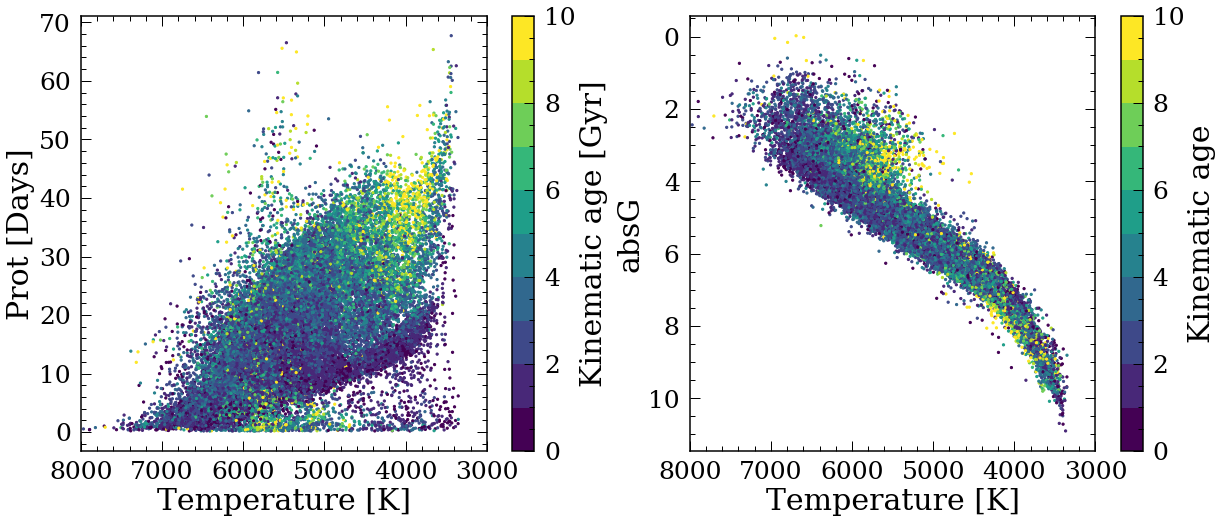

In [37]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
cm = plt.cm.get_cmap('viridis',10)

plt.scatter(df_ruth['color_teffs'],df_ruth['Prot'],c=df_ruth['kin_age'],s=5,vmin=0,vmax=10,cmap=cm,edgecolors=None)
plt.xlim([3000,8000])
plt.xlabel('Temperature [K]')
plt.gca().invert_xaxis()
plt.ylabel('Prot [Days]')

cb=plt.colorbar()

cb.set_label('Kinematic age [Gyr]')

plt.subplot(1,2,2)
cm = plt.cm.get_cmap('viridis',10)
plt.xlim([3000,8000])
plt.scatter(df_ruth['color_teffs'],df_ruth['abs_G'],c=df_ruth['kin_age'],s=5,vmin=0,vmax=10,cmap=cm,edgecolors=None)

plt.xlabel('Temperature [K]')
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.ylabel('absG')

cb=plt.colorbar()

cb.set_label('Kinematic age')



In [4]:
# read in AS stars

# gaia data from https://gaia-kepler.fun/
with fits.open('../FirstYearML/kepler_dr2_1arcsec.fits') as data_ga:
    print(np.shape(data_ga[1].data))
    gaia = pd.DataFrame(data_ga[1].data, dtype="float64")
#print(gaia)

ASstars=pd.read_table('/Users/lucy/Desktop/KeplerAges/ASage.webarchive',delimiter=',',skiprows=2)
ASstars=ASstars.dropna(subset=['KIC'])

seismicKID=[12069424,12069449,3427720,3656476,5184732,6116048,6196457,6521045,7680114,7871531,8006161,8349582,
           9098294,9139151,9955598,10454113,10586004,10644253,10963065,11244118,11401755]

seismicAge=[7.07,6.82,2.23,8.13,4.17,6.23,5.51,6.24,7.19,9.15,5.04,7.93,7.28,1.71,6.43,2.03,6.35,
            1.07,4.36,6.43,5.85]
seismicAge_err=[0.46,0.28,0.17,0.59,0.40,0.37,0.71,0.37,0.70,0.47,0.17,0.94,0.51,0.19,0.47,0.29,
                1.37,0.25,0.46,0.58,0.93]


for i in ASstars['KIC'].unique():
    AS_single=ASstars.loc[ASstars['KIC']==i]
    seismicKID.append(int(i))
    seismicAge.append(np.mean(AS_single['Age']))
    seismicAge_err.append((max(AS_single['Age'])-min(AS_single['Age']))/2.)

ASstars_van=pd.read_table('/Users/lucy/Desktop/KeplerAges/VanSand.txt',delimiter=',')

seismicKID=np.append(seismicKID,ASstars_van['KIC'].values)    
seismicAge=np.append(seismicAge,ASstars_van['AMP_age'].values)    
seismicAge_err=np.append(seismicAge_err,ASstars_van['AMP_age_err'].values)    
    
All_ASstars=pd.DataFrame(np.array((seismicKID,seismicAge,seismicAge_err)).T,
                        columns=['KID','ASAge','ASAge_err'])


All_ASstars=pd.merge(All_ASstars,gaia,left_on='KID',right_on='kepid',how='inner')
All_ASstars=All_ASstars.drop_duplicates(keep='first')
print(np.shape(All_ASstars))

pred_period = 10**gk_rotation_model(np.log10(All_ASstars.ASAge.values*1e9), All_ASstars.phot_bp_mean_mag - All_ASstars.phot_rp_mean_mag)
All_ASstars['predict_period']=pred_period
"""
# only use vansandar stars
ASstars_van=pd.read_table('/Users/lucy/Desktop/KeplerAges/VanSand.txt',delimiter=',')
All_ASstars=pd.merge(ASstars_van,gaia,left_on='KIC',right_on='kepid',how='inner')
All_ASstars['abs_G']=m_to_M(All_ASstars['phot_g_mean_mag'], 1./All_ASstars['parallax'])

All_ASstars['KID']=findstars(df_ruth,All_ASstars['teff_x'],All_ASstars['period'],All_ASstars['abs_G'])
pred_period = 10**gk_rotation_model(np.log10(All_ASstars.AMP_age.values*1e9), All_ASstars.phot_bp_mean_mag - All_ASstars.phot_rp_mean_mag)
All_ASstars['predict_period']=pred_period
m=abs(All_ASstars['predict_period']-All_ASstars['period'])<5
All_ASstars=All_ASstars[m]
print(np.shape(All_ASstars))
"""


(201312,)
(86, 137)


"\n# only use vansandar stars\nASstars_van=pd.read_table('/Users/lucy/Desktop/KeplerAges/VanSand.txt',delimiter=',')\nAll_ASstars=pd.merge(ASstars_van,gaia,left_on='KIC',right_on='kepid',how='inner')\nAll_ASstars['abs_G']=m_to_M(All_ASstars['phot_g_mean_mag'], 1./All_ASstars['parallax'])\n\nAll_ASstars['KID']=findstars(df_ruth,All_ASstars['teff_x'],All_ASstars['period'],All_ASstars['abs_G'])\npred_period = 10**gk_rotation_model(np.log10(All_ASstars.AMP_age.values*1e9), All_ASstars.phot_bp_mean_mag - All_ASstars.phot_rp_mean_mag)\nAll_ASstars['predict_period']=pred_period\nm=abs(All_ASstars['predict_period']-All_ASstars['period'])<5\nAll_ASstars=All_ASstars[m]\nprint(np.shape(All_ASstars))\n"

In [5]:
All_ASstars

KID      ASAge  ASAge_err   solution_id  \
0    12069424.0   7.070000    0.46000  1.635721e+18   
1    12069424.0   6.973883    0.42960  1.635721e+18   
3    12069449.0   6.820000    0.28000  1.635721e+18   
4    12069449.0   7.088967    0.23710  1.635721e+18   
6     3427720.0   2.230000    0.17000  1.635721e+18   
..          ...        ...        ...           ...   
102  11772920.0  10.203517    0.66100  1.635721e+18   
103  12009504.0   3.743300    0.51110  1.635721e+18   
104  12069127.0   1.848333    0.12575  1.635721e+18   
105  12258514.0   4.514033    0.86915  1.635721e+18   
106  12317678.0   2.414633    1.13185  1.635721e+18   

                      designation     source_id  random_index  gaia_ref_epoch  \
0    Gaia DR2 2135550755683405952  2.135551e+18  4.015756e+08          2015.5   
1    Gaia DR2 2135550755683405952  2.135551e+18  4.015756e+08          2015.5   
3    Gaia DR2 2135550755683407232  2.135551e+18  1.660575e+08          2015.5   
4    Gaia DR2 2135550755683407232  2.135551e+18  1.660575e+08          2015.5   
6    Gaia DR2 2099985402815368704  2.099985e+18  1.356349e+09          2015.5   
..                            ...           ...           ...             ...   
102  Gaia DR2 2135275740337869056  2.135276e+18  1.500761e+09          2015.5   
103  Gaia DR2 2133099635026671488  2.133100e+18  2.906804e+08          2015.5   
104  Gaia DR2 2135179700570225024  2.135180e+18  6.806487e+08          2015.5   
105  Gaia DR2 2136139475439597184  2.136139e+18  1.138587e+09          2015.5   
106  Gaia DR2 2135483028339642368  2.135483e+18  1.061562e+09          2015.5   

             ra  ra_error  ...  prov_sec  nconfp  nkoi  ntce   jmag   hmag  \
0    295.452970  0.030352  ...      DSEP     0.0   0.0   0.0  5.091  4.724   
1    295.452970  0.030352  ...      DSEP     0.0   0.0   0.0  5.091  4.724   
3    295.465642  0.022583  ...      DSEP     1.0   0.0   0.0  4.993  4.695   
4    295.465642  0.022583  ...      DSEP     1.0   0.0   0.0  4.993  4.695   
6    286.438256  0.021006  ...      DSEP     0.0   0.0   0.0  8.094  7.843   
..          ...       ...  ...       ...     ...   ...   ...    ...    ...   
102  296.441846  0.025694  ...      DSEP     0.0   0.0   0.0  8.435  8.031   
103  289.440885  0.021180  ...      DSEP     0.0   0.0   0.0  8.373  8.149   
104  295.303272  0.020980  ...      DSEP     0.0   0.0   0.0  9.733  9.524   
105  291.592239  0.026103  ...      DSEP     0.0   0.0   0.0  7.035  6.797   
106  296.657238  0.083293  ...      DSEP     0.0   0.0   0.0  7.883  7.655   

      kmag  planet?  kepler_gaia_ang_dist  predict_period  
0    4.426     none              0.022439       34.518144  
1    4.426     none              0.022439       34.213746  
3    4.651     conf              0.057565       34.803445  
4    4.651     conf              0.057565       35.685559  
6    7.826     none              0.029800       12.137496  
..     ...      ...                   ...             ...  
102  7.981     none              0.053119       56.567089  
103  8.069     none              0.067441       12.522157  
104  9.494     none              0.063575        7.068682  
105  6.758     none              0.307228       19.360004  
106  7.631     none              0.068476        3.362202  

[86 rows x 138 columns]

In [6]:
df_culsters=pd.read_pickle('clusters.pkl')
clusters=df_culsters['CLUSTER']
ageerr=np.zeros(len(clusters))
for i in range(len(clusters)):
    if clusters[i]=='Pleiades':
        ageerr[i]=10
    if clusters[i]=='Praesepe':
        ageerr[i]=100
    if clusters[i]=='Hyades':
        ageerr[i]=100
    if clusters[i]=='NGC_6811':
        ageerr[i]=0.05*1e3
    if clusters[i]=='NGC_752':
        ageerr[i]=0.1*1e3
    if clusters[i]=='NGC_6819':
        ageerr[i]=0.1*1e3
    if clusters[i]=='Ruprecht_147':
        ageerr[i]=0.2*1e3
df_culsters['AGE_err']=ageerr
df_culsters.to_pickle('clusters.pkl')




In [7]:

    
def compstars(df,err=True,ave=False,IOfile=False):
    # AS stars
    AScomp=pd.merge(All_ASstars,df,left_on='KID',right_on='KID',how='inner')
    print(np.shape(AScomp))
    AScomp=AScomp.loc[abs(AScomp['predict_period']-AScomp['Prot'])<5]
    print(np.shape(AScomp))
    
    # clusters
    df_culsters=pd.read_pickle('clusters.pkl')
    df_CLUSTERS=pd.merge(df_culsters,df[['KID','kin_age']],left_on='KID',right_on='KID',how='inner')
    ages=[]
    ages_err=[]
    ages_cluster=[]
    ages_cluster_err=[]
    for name in df_CLUSTERS.CLUSTER.unique():
        dfProt_cluster_single=df_CLUSTERS.loc[df_CLUSTERS['CLUSTER']==name].reset_index(drop=True)
    
        mask1=dfProt_cluster_single['PROT']<3
        mask2=dfProt_cluster_single['TEFF']>6000
    
        mask=mask1&mask2
    
        mask1=dfProt_cluster_single['PROT']<5
        mask2=dfProt_cluster_single['TEFF']>5000
        mask3=dfProt_cluster_single['TEFF']<6000
    
        mask=mask|(mask1&mask2&mask3)
    
        mask1=dfProt_cluster_single['PROT']<10
        mask2=dfProt_cluster_single['TEFF']>4200
        mask3=dfProt_cluster_single['TEFF']<5000
    
        mask=mask|(mask1&mask2&mask3)
    
        mask1=dfProt_cluster_single['PROT']<20
        mask2=dfProt_cluster_single['TEFF']>2000
        mask3=dfProt_cluster_single['TEFF']<4200
    
        mask=mask|(mask1&mask2&mask3)
    
        dfProt_cluster_single=dfProt_cluster_single[~mask]
        
        #temprange=[0,5300]
        #dfProt_cluster_single=dfProt_cluster_single.loc[dfProt_cluster_single['TEFF']>temprange[0]]
        #dfProt_cluster_single=dfProt_cluster_single.loc[dfProt_cluster_single['TEFF']<temprange[1]]
        
        if len(dfProt_cluster_single)==0:
            continue
        print(name)
        ages.append(np.mean(dfProt_cluster_single['kin_age']))
        ages_err.append(np.std(dfProt_cluster_single['kin_age']))
        ages_cluster.append(dfProt_cluster_single['AGE'].values[0]/1000)
        ages_cluster_err.append(dfProt_cluster_single['AGE_err'].values[0]/1000)

    
    # Isochrone stars
    df_isoages=pd.read_table('GKSPCPapTable2.txt',delimiter='&')
    IAcomp=pd.merge(df_isoages,df,left_on='KIC',right_on='KID',how='inner')

    if ave:
        IAcomp['vel_dis'],IAcomp['iso_age_ave'],IAcomp['iso_age_ave_err']=getAveAges(IAcomp,['color_teffs','Prot_log','abs_G','Ro'],
                                    [150.0, 0.2333333333333334, 0.4555555555555556, 0.14444444444444446],vz='all_vz')
    
    if IOfile:
        IAcomp=np.load('XD_prot.npy')
    else:
        IAcomp=IAcomp.loc[IAcomp['iso_age']<10]
        IAcomp=IAcomp.loc[IAcomp['iso_age_err1']<3]
        IAcomp=IAcomp.loc[IAcomp['Ro']<2.08]
        
    if ave:
        IAcomp.to_pickle('IsoStars.pkl')
        
        
    # WD ages
    WDKID=[12456401,11075611]
    WDage=[3.59,3.64]
    WDage_err=[4.92,3.05]
    df_WDage=pd.DataFrame(np.array((WDKID,WDage,WDage_err)).T,columns=['KID','WDage','WDage_err'])
    df_WDcomp=pd.merge(df_WDage,df[['KID','kin_age','kin_age_err']],left_on='KID',right_on='KID',how='inner')
    
    
    plt.figure(figsize=(10,8))
    if err:
        plt.errorbar(AScomp['ASAge'],AScomp['kin_age'],xerr=AScomp['ASAge_err'],yerr=AScomp['kin_age_err'],fmt='go',label='AS ages')
        print('for AS stars RMS',np.sqrt(((AScomp['kin_age'] - AScomp['ASAge']) ** 2).mean()))
        print('for AS stars MAD',np.median(abs((AScomp['kin_age'] - AScomp['ASAge']))))
    else:
        plt.errorbar(AScomp['ASAge'],AScomp['kin_age'],xerr=AScomp['ASAge_err'],fmt='go',label='AS ages')
    if IOfile:
        plt.plot(IAcomp[:, 0], IAcomp[:, 1],'k.',markersize=4,label='Iso ages')
    elif ave:
        plt.plot(IAcomp['iso_age_ave'],IAcomp['kin_age'],'k.',markersize=1,label='Iso ages')
    else:
        plt.plot(IAcomp['iso_age'],IAcomp['kin_age'],'k.',markersize=1,label='Iso ages')
    
    AScomp.to_pickle('ASComp.pkl')
    pd.DataFrame(np.array((ages_cluster,ages,ages_err)).T,columns=['ClusterAge','kina_age','kin_age_err']).to_pickle('OCComp.pkl')
    ages=np.array(ages)
    ages_cluster=np.array(ages_cluster)
    plt.errorbar(ages_cluster,ages,xerr=ages_cluster_err,yerr=ages_err,fmt='ro',label='Clusters')
    print('for cluster RMS',np.sqrt(((ages - ages_cluster) ** 2).mean()))
    print('for cluster MAD',np.median(abs((ages - ages_cluster))))
        
    plt.errorbar(df_WDcomp['WDage'],df_WDcomp['kin_age'],xerr=df_WDcomp['WDage_err'],yerr=df_WDcomp['kin_age_err'],fmt='bo',label='WD ages')
    plt.plot([0,10],[0,10])
    #plt.yscale('log')
    #plt.xscale('log')
    plt.xlim([0,10])
    plt.ylim([0,10])
    plt.legend()
    plt.ylabel('Gyro-Kinematic Age [Gyr]')
    plt.xlabel('Measured Age [Gyr]')
    plt.savefig('All_comp.png')
    

## optimize bin size

In [8]:
#df_ruth['feh']

NameError: name 'df_ruth' is not defined

In [ ]:
df_ruth['teff_calc']=df_ruth['color_teffs']

ASstars=pd.merge(df_ruth,All_ASstars,left_on='KID',right_on='KID',how='inner')
ASstars=ASstars.loc[abs(ASstars['Prot']-ASstars['predict_period'])<5]

df_ruth=df_ruth.reset_index(drop=True)
ASstars=ASstars.reset_index(drop=True)



optbin,out_comp,chisq=optimizeBins(df_ruth,ASstars,['color_teffs','Prot_log','abs_G','Ro'],
                             [50,0.1,0.1,0.1],[500,0.5,0.5,0.5],df_match_name='ASAge',
                             min_star=0,max_star=300,
                             df_match_name_err='ASAge_err',vz='all_vz',bintestNo=10,errVals=False)
 
""" 
optbin,out_comp,chisq=optimizeBins(df_ruth,ASstars,['teff_calc','Prot_log','abs_G','Ro'],
                             [150.0, 0.2333333333333334, 0.4555555555555556, 0.14444444444444446],[150.0, 0.2333333333333334, 0.4555555555555556, 0.14444444444444446],
                             min_star=15,max_star=30,df_match_name='ASAge',df_match_name_err='ASAge_err',vz='all_vz',bintestNo=1,errVals=True)
""" 

 14%|█▍        | 1413/10000 [00:09<00:48, 178.74it/s]

In [14]:
print('optimized bin size:',optbin,'. with chisq:',chisq)
plt.figure(figsize=(10,8))

plt.errorbar(out_comp['measure_age'],out_comp['kin_age'],xerr=out_comp['measure_age_err'],
             yerr=out_comp['measure_age_err'],fmt='r.')
"""
plt.scatter(out_comp['kin_age'],out_comp['measure_age'],c=out_comp['NumbStars'])
"""
plt.plot([0,10],[0,10])
plt.xlabel('Measured Ages')
plt.ylabel('Kinematic Ages')
plt.figure(figsize=(10,8))
out_comp['NumbStars'].hist(bins=100)

NameError: name 'optbin' is not defined

In [41]:
df_ruth['Ro']=df_ruth['Prot']/stardate.convective_overturn_time(df_ruth['mass'])
df_ruth['teff_calc']=df_ruth['color_teffs']
df_isoages=pd.read_table('GKSPCPapTable2.txt',delimiter='&')
IAcomp=pd.merge(df_isoages,df_ruth[['color_teffs','teff_calc','Prot_log','abs_G','Ro','all_vz','KID','kin_age_err']],left_on='KIC',right_on='KID',how='inner')
IAcomp=IAcomp.loc[IAcomp['iso_age']<10]
IAcomp=IAcomp.loc[IAcomp['iso_age_err1']<3]

IAcomp=IAcomp.loc[IAcomp['Ro']<2.08]

In [42]:
IAcomp['iso_age']

1        1.44
7        2.05
17       1.51
19       1.03
22       1.11
         ... 
29919    5.01
29937    0.66
29938    2.93
29940    1.98
29946    3.54
Name: iso_age, Length: 8616, dtype: float64

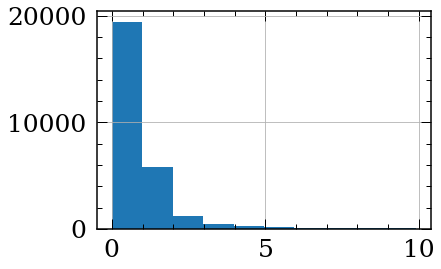

In [606]:
df_plot=df_ruth.loc[df_ruth['kin_age_err']<10]
df_plot['kin_age_err'].hist()

In [37]:
df_ruth['Ro']=df_ruth['Prot']/stardate.convective_overturn_time(df_ruth['mass'])
df_ruth['teff_calc']=df_ruth['color_teffs']
df_isoages=pd.read_table('GKSPCPapTable2.txt',delimiter='&')
IAcomp=pd.merge(df_isoages,df_ruth[['color_teffs','teff_calc','Prot_log','abs_G','Ro','all_vz','KID','kin_age_err']],left_on='KIC',right_on='KID',how='inner')
IAcomp=IAcomp.loc[IAcomp['iso_age']<10]
IAcomp=IAcomp.loc[IAcomp['iso_age_err1']<3]

IAcomp=IAcomp.loc[IAcomp['Ro']<2.08]

In [35]:
#df_ruth=pd.read_pickle('Kinages_Prot.pkl')

In [72]:
"""
optbin,out_comp,chisq=optimizeBins(df_ruth[['color_teffs','teff_calc','Prot_log','abs_G','Ro','all_vz','KID','kin_age_err']],IAcomp,['color_teffs','Prot_log','abs_G','Ro'],
                             [150.0, 0.2333333333333334, 0.4555555555555556, 0.14444444444444446],[150.0, 0.23333333333333334, 0.4555555555555556, 0.14444444444444446],df_match_name='iso_age',
                                   min_star=15,max_star=30,df_match_name_err='iso_age_err1',vz='all_vz',bintestNo=1,errVals=True)
"""
mins=[10,15,20]
maxs=[30,100,200,300]

chisqmin=100
minstarmin=0
maxstarmin=0

chisqmins=[]
minstarmins=[]
maxstarmins=[]

optbin=[250.0, 0.2777777777777778, 0.4111111111111111, 0.14444444444444446]

for i in mins:
    for j in maxs:
        optbin,out_comp,chisq=optimizeBins(df_ruth,IAcomp,['color_teffs','Prot_log','abs_G','Ro'],
                             optbin,optbin,df_match_name='iso_age',
                            min_star=i,max_star=j,df_match_name_err='iso_age_err1',vz='all_vz',bintestNo=1,errVals=False)
        if chisq<chisqmin:
            chisqmin=chisq
            minstarmin=i
            maxstarmin=j
        chisqmins.append(chisq)
        minstarmins.append(i)
        maxstarmins.append(j)
        
            
#[150.0, 0.14444444444444443, 0.4555555555555556, 0.14444444444444446]
#[500.0, 0.5, 0.46, 0.5]

  1%|          | 79/8616 [00:00<00:10, 787.14it/s]

[250.0, 0.2777777777777778, 0.4111111111111111, 0.14444444444444446]


  0%|          | 0/1 [00:00<?, ?it/s]

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
8611    0.0
8612    0.0
8613    0.0
8614    0.0
8615    0.0
Name: kin_age, Length: 8616, dtype: float64


  1%|          | 97/8616 [00:00<00:08, 953.25it/s]

[250.0, 0.2777777777777778, 0.4111111111111111, 0.14444444444444446]


  0%|          | 0/1 [00:00<?, ?it/s]

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
8611    0.0
8612    0.0
8613    0.0
8614    0.0
8615    0.0
Name: kin_age, Length: 8616, dtype: float64


  3%|▎         | 250/8616 [00:00<00:06, 1274.72it/s]

[250.0, 0.2777777777777778, 0.4111111111111111, 0.14444444444444446]


  0%|          | 0/1 [00:00<?, ?it/s]

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
8611    0.0
8612    0.0
8613    0.0
8614    0.0
8615    0.0
Name: kin_age, Length: 8616, dtype: float64


  3%|▎         | 244/8616 [00:00<00:06, 1252.49it/s]

[250.0, 0.2777777777777778, 0.4111111111111111, 0.14444444444444446]


  0%|          | 0/1 [00:00<?, ?it/s]

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
8611    0.0
8612    0.0
8613    0.0
8614    0.0
8615    0.0
Name: kin_age, Length: 8616, dtype: float64


  1%|          | 62/8616 [00:00<00:13, 614.00it/s]

[250.0, 0.2777777777777778, 0.4111111111111111, 0.14444444444444446]


  0%|          | 0/1 [00:00<?, ?it/s]

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
8611    0.0
8612    0.0
8613    0.0
8614    0.0
8615    0.0
Name: kin_age, Length: 8616, dtype: float64


  1%|          | 105/8616 [00:00<00:08, 1048.72it/s]

[250.0, 0.2777777777777778, 0.4111111111111111, 0.14444444444444446]


  0%|          | 0/1 [00:00<?, ?it/s]

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
8611    0.0
8612    0.0
8613    0.0
8614    0.0
8615    0.0
Name: kin_age, Length: 8616, dtype: float64


  3%|▎         | 224/8616 [00:00<00:07, 1126.20it/s]

[250.0, 0.2777777777777778, 0.4111111111111111, 0.14444444444444446]


  0%|          | 0/1 [00:00<?, ?it/s]

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
8611    0.0
8612    0.0
8613    0.0
8614    0.0
8615    0.0
Name: kin_age, Length: 8616, dtype: float64


  1%|▏         | 116/8616 [00:00<00:07, 1152.19it/s]

[250.0, 0.2777777777777778, 0.4111111111111111, 0.14444444444444446]


  0%|          | 0/1 [00:00<?, ?it/s]

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
8611    0.0
8612    0.0
8613    0.0
8614    0.0
8615    0.0
Name: kin_age, Length: 8616, dtype: float64


  1%|          | 64/8616 [00:00<00:13, 629.43it/s]

[250.0, 0.2777777777777778, 0.4111111111111111, 0.14444444444444446]


  0%|          | 0/1 [00:00<?, ?it/s]

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
8611    0.0
8612    0.0
8613    0.0
8614    0.0
8615    0.0
Name: kin_age, Length: 8616, dtype: float64


  1%|          | 70/8616 [00:00<00:12, 665.70it/s]

[250.0, 0.2777777777777778, 0.4111111111111111, 0.14444444444444446]


  0%|          | 0/1 [00:00<?, ?it/s]

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
8611    0.0
8612    0.0
8613    0.0
8614    0.0
8615    0.0
Name: kin_age, Length: 8616, dtype: float64


  1%|          | 99/8616 [00:00<00:08, 987.76it/s]

[250.0, 0.2777777777777778, 0.4111111111111111, 0.14444444444444446]


  0%|          | 0/1 [00:00<?, ?it/s]

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
8611    0.0
8612    0.0
8613    0.0
8614    0.0
8615    0.0
Name: kin_age, Length: 8616, dtype: float64


  1%|          | 102/8616 [00:00<00:08, 1013.81it/s]

[250.0, 0.2777777777777778, 0.4111111111111111, 0.14444444444444446]


100%|██████████| 8616/8616 [00:08<00:00, 1064.55it/s]


0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
8611    0.0
8612    0.0
8613    0.0
8614    0.0
8615    0.0
Name: kin_age, Length: 8616, dtype: float64


In [73]:
chisqmin,minstarmin,maxstarmin

(100, 0, 0)

In [74]:
chisqmins

[317.2929272462624,
 317.1987605423982,
 317.196796530544,
 317.1967313531188,
 315.9851607229728,
 315.8818767777934,
 315.87991276593925,
 315.8798475885141,
 314.6411385884451,
 314.59779086748836,
 314.5958268556341,
 314.595761678209]

In [62]:
minstarmins,maxstarmins

([10, 10, 10, 10, 15, 15, 15, 15, 20, 20, 20, 20],
 [30, 100, 200, 300, 30, 100, 200, 300, 30, 100, 200, 300])

In [ ]:
10,200

optimized bin size: [150.0, 0.14, 0.46, 0.14] . with chisq: 0.970891108489876


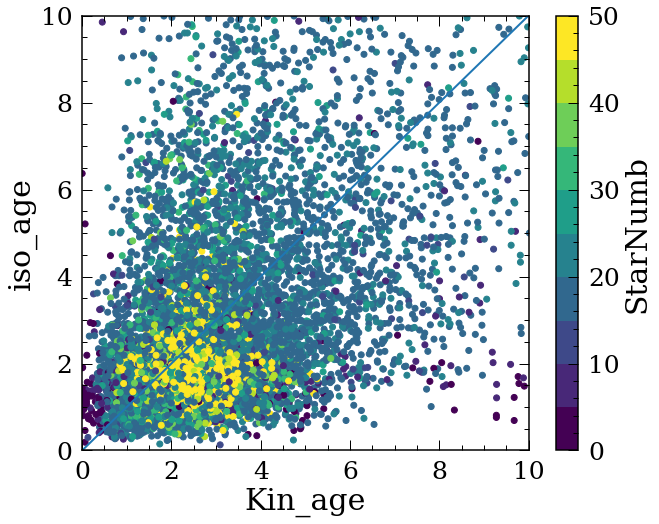

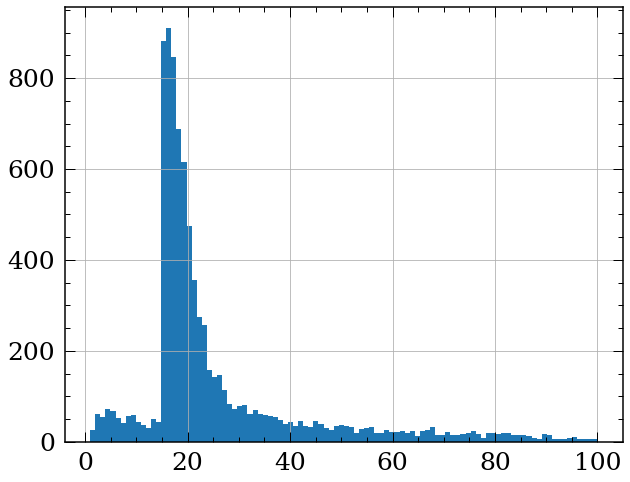

In [53]:
print('optimized bin size:',optbin,'. with chisq:',chisq)
plt.figure(figsize=(10,8))
"""
#plt.errorbar(out_comp['kin_age'],out_comp['measure_age'],yerr=out_comp['measure_age_err'],fmt='r.',alpha=0.1)
plt.plot(out_comp['kin_age'],out_comp['measure_age'],'r.',markersize=1)
"""

cm = plt.cm.get_cmap('viridis',10)
#out_comp_plot=out_comp.loc[out_comp['NumbStars']>0].dropna()
#out_comp_plot=out_comp_plot.loc[out_comp_plot['NumbStars']<100].dropna()
#print(calcChi2(out_comp_plot['kin_age'],out_comp_plot['measure_age'],out_comp_plot['measure_age_err']))
plt.scatter(out_comp_plot['kin_age'],out_comp_plot['measure_age'],c=out_comp_plot['NumbStars'],cmap=cm,vmin=0,vmax=50)
cb=plt.colorbar()
cb.set_label('StarNumb')

plt.plot([0,10],[0,10])
plt.xlabel('Kin_age')
plt.ylabel('iso_age')
plt.xlim([0,10])
plt.ylim([0,10])

plt.figure(figsize=(10,8))
out_comp['NumbStars'].hist(bins=100)

optimized bin size: [500.0, 0.1, 0.5, 0.4] . with chisq: 0.8741206099085425
0.8741206099085477


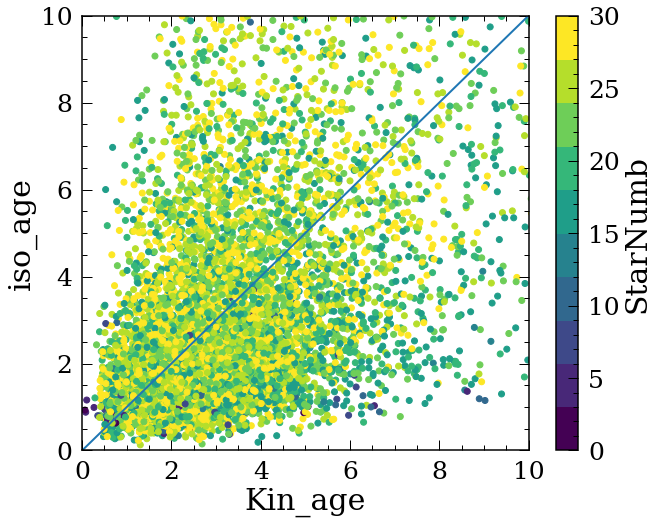

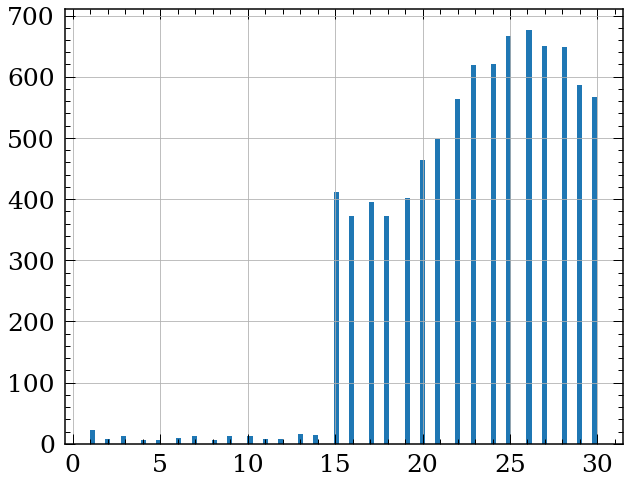

In [710]:
print('optimized bin size:',optbin,'. with chisq:',chisq)
plt.figure(figsize=(10,8))
"""
#plt.errorbar(out_comp['kin_age'],out_comp['measure_age'],yerr=out_comp['measure_age_err'],fmt='r.',alpha=0.1)
plt.plot(out_comp['kin_age'],out_comp['measure_age'],'r.',markersize=1)
"""

cm = plt.cm.get_cmap('viridis',10)
out_comp_plot=out_comp.loc[out_comp['NumbStars']>0].dropna()
out_comp_plot=out_comp_plot.loc[out_comp_plot['NumbStars']<100].dropna()
print(calcChi2(out_comp_plot['kin_age'],out_comp_plot['measure_age'],out_comp_plot['kin_age_err'],out_comp_plot['measure_age_err']))
plt.scatter(out_comp_plot['kin_age'],out_comp_plot['measure_age'],c=out_comp_plot['NumbStars'],cmap=cm,vmin=0,vmax=30)
cb=plt.colorbar()
cb.set_label('StarNumb')

plt.plot([0,10],[0,10])
plt.xlabel('Kin_age')
plt.ylabel('iso_age')
plt.xlim([0,10])
plt.ylim([0,10])

plt.figure(figsize=(10,8))
out_comp['NumbStars'].hist(bins=100)

In [48]:
All_ASstars

KID      ASAge  ASAge_err   solution_id  \
0    12069424.0   7.070000    0.46000  1.635721e+18   
1    12069424.0   6.973883    0.42960  1.635721e+18   
3    12069449.0   6.820000    0.28000  1.635721e+18   
4    12069449.0   7.088967    0.23710  1.635721e+18   
6     3427720.0   2.230000    0.17000  1.635721e+18   
..          ...        ...        ...           ...   
102  11772920.0  10.203517    0.66100  1.635721e+18   
103  12009504.0   3.743300    0.51110  1.635721e+18   
104  12069127.0   1.848333    0.12575  1.635721e+18   
105  12258514.0   4.514033    0.86915  1.635721e+18   
106  12317678.0   2.414633    1.13185  1.635721e+18   

                      designation     source_id  random_index  gaia_ref_epoch  \
0    Gaia DR2 2135550755683405952  2.135551e+18  4.015756e+08          2015.5   
1    Gaia DR2 2135550755683405952  2.135551e+18  4.015756e+08          2015.5   
3    Gaia DR2 2135550755683407232  2.135551e+18  1.660575e+08          2015.5   
4    Gaia DR2 2135550755683407232  2.135551e+18  1.660575e+08          2015.5   
6    Gaia DR2 2099985402815368704  2.099985e+18  1.356349e+09          2015.5   
..                            ...           ...           ...             ...   
102  Gaia DR2 2135275740337869056  2.135276e+18  1.500761e+09          2015.5   
103  Gaia DR2 2133099635026671488  2.133100e+18  2.906804e+08          2015.5   
104  Gaia DR2 2135179700570225024  2.135180e+18  6.806487e+08          2015.5   
105  Gaia DR2 2136139475439597184  2.136139e+18  1.138587e+09          2015.5   
106  Gaia DR2 2135483028339642368  2.135483e+18  1.061562e+09          2015.5   

             ra  ra_error  ...  prov_sec  nconfp  nkoi  ntce   jmag   hmag  \
0    295.452970  0.030352  ...      DSEP     0.0   0.0   0.0  5.091  4.724   
1    295.452970  0.030352  ...      DSEP     0.0   0.0   0.0  5.091  4.724   
3    295.465642  0.022583  ...      DSEP     1.0   0.0   0.0  4.993  4.695   
4    295.465642  0.022583  ...      DSEP     1.0   0.0   0.0  4.993  4.695   
6    286.438256  0.021006  ...      DSEP     0.0   0.0   0.0  8.094  7.843   
..          ...       ...  ...       ...     ...   ...   ...    ...    ...   
102  296.441846  0.025694  ...      DSEP     0.0   0.0   0.0  8.435  8.031   
103  289.440885  0.021180  ...      DSEP     0.0   0.0   0.0  8.373  8.149   
104  295.303272  0.020980  ...      DSEP     0.0   0.0   0.0  9.733  9.524   
105  291.592239  0.026103  ...      DSEP     0.0   0.0   0.0  7.035  6.797   
106  296.657238  0.083293  ...      DSEP     0.0   0.0   0.0  7.883  7.655   

      kmag  planet?  kepler_gaia_ang_dist  predict_period  
0    4.426     none              0.022439       34.518144  
1    4.426     none              0.022439       34.213746  
3    4.651     conf              0.057565       34.803445  
4    4.651     conf              0.057565       35.685559  
6    7.826     none              0.029800       12.137496  
..     ...      ...                   ...             ...  
102  7.981     none              0.053119       56.567089  
103  8.069     none              0.067441       12.522157  
104  9.494     none              0.063575        7.068682  
105  6.758     none              0.307228       19.360004  
106  7.631     none              0.068476        3.362202  

[86 rows x 138 columns]

# Final compare

In [15]:

df_ruth['Prot_log']=np.log10(df_ruth['Prot'])
df_ruth['vel_dis'],df_ruth['kin_age']=getkinAges(df_ruth,['color_teffs','Prot_log','abs_G','Ro'],
                                                 [250.0, 0.2777777777777778, 0.4111111111111111, 0.14444444444444446],
                                                 vz='all_vz',min_star=10,max_star=200)


"""
testing=10000
px_s=getErr(df['parallax'].values,df['parallax_error'].values,testing)
pmra_s=getErr(df['pmra'].values,df['pmra_error'].values,testing)
pmdec_s=getErr(df['pmdec'].values,df['pmdec_error'].values,testing)
ra_s=getErr(df['ra'].values,df['ra_error'].values,testing)
dec_s=getErr(df['dec'].values,df['dec_error'].values,testing)

"""

100%|██████████| 29949/29949 [00:25<00:00, 1152.26it/s]

8912



/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in log
/Users/lucy/anaconda3/lib/python3.7/site-packages/numpy/lib/polynomial.py:734: RuntimeWarning: invalid value encountered in multiply
  y = y * x + p[i]


"\ntesting=10000\npx_s=getErr(df['parallax'].values,df['parallax_error'].values,testing)\npmra_s=getErr(df['pmra'].values,df['pmra_error'].values,testing)\npmdec_s=getErr(df['pmdec'].values,df['pmdec_error'].values,testing)\nra_s=getErr(df['ra'].values,df['ra_error'].values,testing)\ndec_s=getErr(df['dec'].values,df['dec_error'].values,testing)\n\n"

In [49]:
df_ruth['kin_age_err']=np.sqrt(df_ruth['kin_age_err']**2+df_ruth['kin_age_err_AVR']**2)

In [50]:
np.median(df_ruth['kin_age_err'])

2.421644249402537

(8, 146)
(6, 146)
Pleiades
Praesepe
Hyades
NGC_752
NGC_6819
NGC_6811
Ruprecht_147
for AS stars RMS 0.2562392648095429
for AS stars MAD 0.20307123591349274
for cluster RMS 1.444130456032783
for cluster MAD 1.0938787923155924


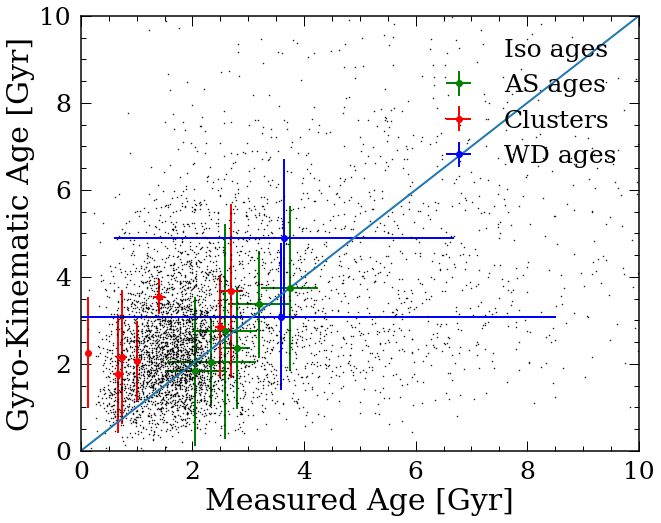

In [11]:
df_ruth=df_ruth.loc[df_ruth['feh']>-0.2]
#df_ruth['kin_age']=df_ruth['age']
compstars(df_ruth[['kin_age','KID','kin_age_err','Prot','color_teffs','abs_G','Prot_log','Ro','all_vz']],
          err=True,IOfile=False,ave=False)


(11, 146)
(6, 146)
Pleiades
Praesepe
Hyades
NGC_752
NGC_6819
NGC_6811
Ruprecht_147
for AS stars RMS 0.2562392648095429
for AS stars MAD 0.20307123591349274
for cluster RMS 1.2213293501782645
for cluster MAD 1.0794611700540964


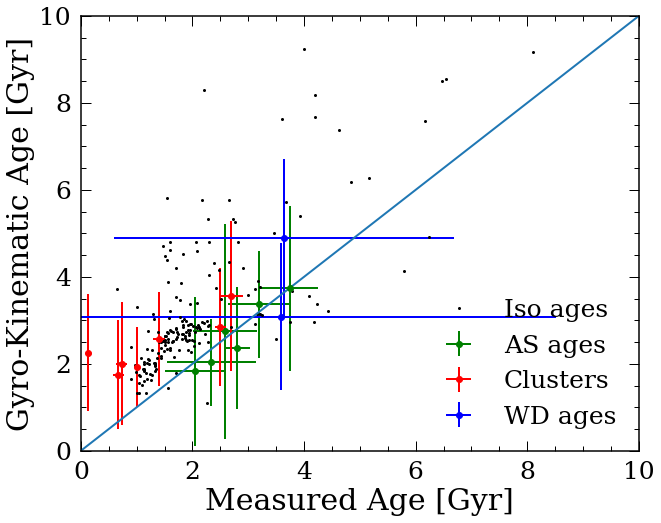

In [36]:
#df_ruth['kin_age']=df_ruth['age']
compstars(df_ruth[['kin_age','KID','kin_age_err','Prot','color_teffs','abs_G','Prot_log','Ro','all_vz']],
          err=True,IOfile=True,ave=False)



In [28]:
df_ruth=pd.read_pickle('df_ruth.pkl')

In [29]:
star1=df_ruth.loc[df_ruth['kepid']==8410374]
star2=df_ruth.loc[df_ruth['kepid']==9848298]
star1['kin_age'].values,star1['kin_age_err'].values,star2['kin_age'].values,star2['kin_age_err'].values

(array([4.66130614]),
 array([1.21099146]),
 array([1.28622404]),
 array([1.10483708]))

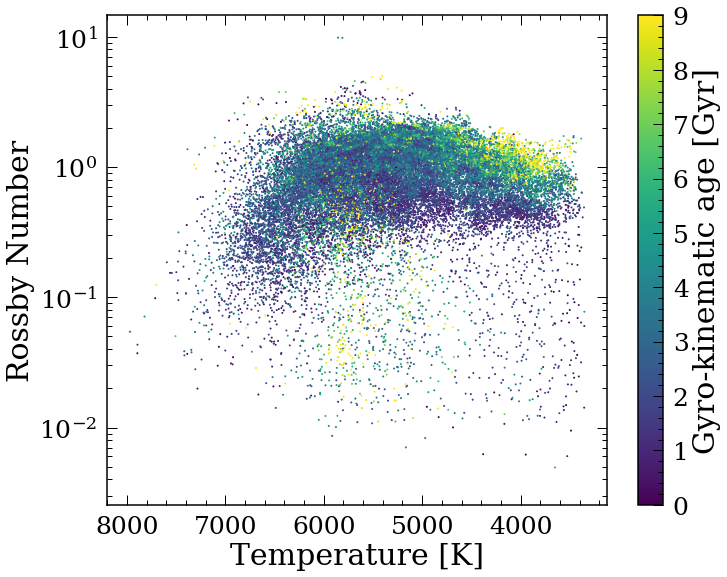

In [31]:
plt.figure(figsize=(10,8))
plt.scatter(df_ruth['color_teffs'],df_ruth['Ro'],c=df_ruth['kin_age'],s=1,vmin=0,vmax=9,edgecolors=None)
plt.xlabel('Temperature [K]')
plt.gca().invert_xaxis()
plt.ylabel('Rossby Number')

cb=plt.colorbar()
cb.set_label('Gyro-kinematic age [Gyr]')
#plt.title('Ages Errors',fontsize=25)
plt.tight_layout()
plt.yscale('log')

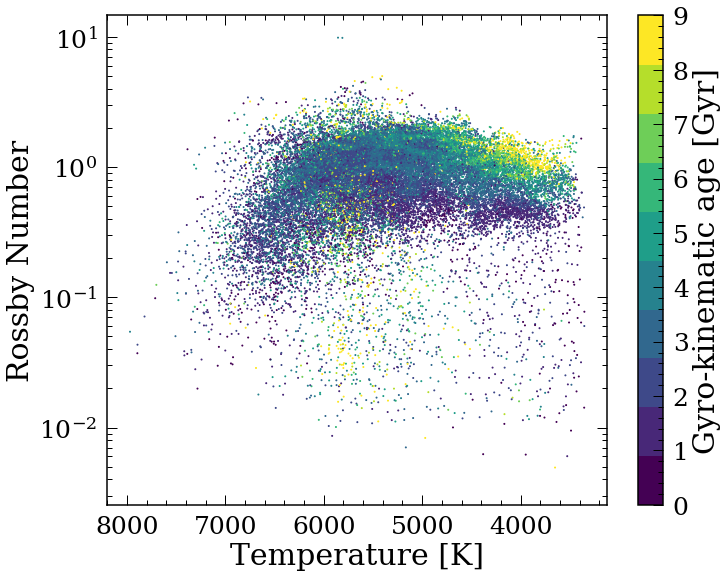

In [82]:
plt.figure(figsize=(10,8))
plt.scatter(df_ruth['color_teffs'],df_ruth['Ro'],c=df_ruth['kin_age'],s=1,vmin=0,vmax=9,cmap=cm,edgecolors=None)
plt.xlabel('Temperature [K]')
plt.gca().invert_xaxis()
plt.ylabel('Rossby Number')

cb=plt.colorbar()
cb.set_label('Gyro-kinematic age [Gyr]')
#plt.title('Ages Errors',fontsize=25)
plt.tight_layout()
plt.yscale('log')

In [2]:
#df_ruth=pd.read_pickle('df_ruth.pkl')


In [3]:
temptest=np.linspace(150*0.8,150*1.2,10)
ages=np.zeros((len(df_ruth),len(temptest)))
for i in range(len(temptest)):
    _,ages[:,i]=getkinAges(df_ruth,['color_teffs','Prot_log','abs_G','Ro'],[temptest[i], 0.2333333333333334, 0.4555555555555556, 0.14444444444444446],
                                                 vz='all_vz',min_star=15,max_star=30)

ageerr=[np.std(pd.Series(ages[i,:]).dropna()) for i in range(len(df_ruth))]
df_ruth['kin_age_temp_err']=ageerr


100%|██████████| 30127/30127 [00:38<00:00, 790.37it/s]
/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in log
/Users/lucy/anaconda3/lib/python3.7/site-packages/numpy/lib/polynomial.py:675: RuntimeWarning: invalid value encountered in multiply
  y = y * x + p[i]
  0%|          | 73/30127 [00:00<00:41, 722.17it/s]

33694


  0%|          | 51/30127 [00:00<00:59, 507.68it/s]

33463


  0%|          | 67/30127 [00:00<00:45, 667.14it/s]

33173


  0%|          | 47/30127 [00:00<01:04, 469.26it/s]

32932


  0%|          | 73/30127 [00:00<00:41, 719.98it/s]

32773


  0%|          | 73/30127 [00:00<00:41, 721.64it/s]

32645


  0%|          | 74/30127 [00:00<00:40, 735.98it/s]

32573


  0%|          | 71/30127 [00:00<00:42, 705.96it/s]

32557


  0%|          | 65/30127 [00:00<00:46, 641.59it/s]

32503


100%|██████████| 30127/30127 [00:35<00:00, 838.59it/s]


32468


In [4]:
Prottest=np.linspace(0.2333333333333334*0.8,0.2333333333333334*1.2,10)
ages=np.zeros((len(df_ruth),len(Prottest)))
for i in range(len(Prottest)):
    _,ages[:,i]=getkinAges(df_ruth,['color_teffs','Prot_log','abs_G','Ro'],[150., Prottest[i], 0.4555555555555556, 0.14444444444444446],
                                                 vz='all_vz',min_star=15,max_star=30)

ageerr=[np.std(pd.Series(ages[i,:]).dropna()) for i in range(len(df_ruth))]
df_ruth['kin_age_prot_err']=ageerr


100%|██████████| 30127/30127 [00:35<00:00, 842.29it/s]
/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in log
  0%|          | 44/30127 [00:00<01:08, 438.39it/s]

33584


  0%|          | 70/30127 [00:00<00:43, 683.77it/s]

33395


  0%|          | 60/30127 [00:00<00:50, 592.95it/s]

33128


  0%|          | 78/30127 [00:00<00:39, 768.63it/s]

32963


  0%|          | 76/30127 [00:00<00:39, 752.88it/s]

32787


  0%|          | 55/30127 [00:00<00:54, 546.91it/s]

32632


  0%|          | 62/30127 [00:00<00:48, 615.44it/s]

32529


  0%|          | 76/30127 [00:00<00:39, 752.76it/s]

32440


  0%|          | 76/30127 [00:00<00:39, 754.28it/s]

32386


100%|██████████| 30127/30127 [00:37<00:00, 799.79it/s]


32276


In [6]:
absgtest=np.linspace(0.4555555555555556*0.8,0.4555555555555556*1.2,10)
ages=np.zeros((len(df_ruth),len(absgtest)))
for i in range(len(absgtest)):
    _,ages[:,i]=getkinAges(df_ruth,['color_teffs','Prot_log','abs_G','Ro'],[150., 0.2333333333333334, absgtest[i], 0.14444444444444446],
                                                 vz='all_vz',min_star=15,max_star=30)

df_ruth['kin_age_absg_err']=ageerr=[np.std(pd.Series(ages[i,:]).dropna()) for i in range(len(df_ruth))]


100%|██████████| 30127/30127 [00:35<00:00, 846.41it/s]
/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in log
  0%|          | 78/30127 [00:00<00:39, 767.35it/s]

33666


  0%|          | 76/30127 [00:00<00:39, 759.36it/s]

33459


  0%|          | 63/30127 [00:00<00:47, 629.32it/s]

33170


  0%|          | 80/30127 [00:00<00:37, 798.72it/s]

32935


  0%|          | 65/30127 [00:00<00:49, 602.85it/s]

32791


  0%|          | 77/30127 [00:00<00:39, 758.03it/s]

32639


  0%|          | 78/30127 [00:00<00:39, 767.63it/s]

32569


  0%|          | 77/30127 [00:00<00:39, 761.18it/s]

32527


  0%|          | 74/30127 [00:00<00:40, 739.80it/s]

32480


100%|██████████| 30127/30127 [00:42<00:00, 713.65it/s]


32441


In [7]:
Rotest=np.linspace(0.14444444444444446*0.8,0.14444444444444446*1.2,10)
ages=np.zeros((len(df_ruth),len(Rotest)))
for i in range(len(Rotest)):
    _,ages[:,i]=getkinAges(df_ruth,['color_teffs','Prot_log','abs_G','Ro'],[150., 0.2333333333333334, 0.4555555555555556, Rotest[i]],
                                                 vz='all_vz',min_star=15,max_star=30)

df_ruth['kin_age_ro_err']=ageerr=[np.std(pd.Series(ages[i,:]).dropna()) for i in range(len(df_ruth))]



100%|██████████| 30127/30127 [00:34<00:00, 866.58it/s]
/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in log
  0%|          | 73/30127 [00:00<00:41, 724.16it/s]

33510


  0%|          | 71/30127 [00:00<00:42, 703.39it/s]

33305


  0%|          | 66/30127 [00:00<00:45, 654.85it/s]

33117


  0%|          | 66/30127 [00:00<00:45, 655.74it/s]

32960


  0%|          | 60/30127 [00:00<00:50, 597.76it/s]

32786


  0%|          | 72/30127 [00:00<00:41, 719.91it/s]

32657


  0%|          | 68/30127 [00:00<00:44, 679.02it/s]

32555


  0%|          | 64/30127 [00:00<00:47, 633.67it/s]

32541


  0%|          | 65/30127 [00:00<00:46, 644.25it/s]

32488


100%|██████████| 30127/30127 [00:41<00:00, 724.02it/s]


32404


In [ ]:
df_ruth=df_ruth.loc[df_ruth['kin_age_temp_err']<2]
df_ruth=df_ruth.loc[df_ruth['kin_age_prot_err']<2]
df_ruth=df_ruth.loc[df_ruth['kin_age_absg_err']<2]
df_ruth=df_ruth.loc[df_ruth['kin_age_ro_err']<2]
df_ruth=df_ruth.loc[df_ruth['kin_age_err']<5]


In [35]:
df_ruth['kin_age_temp_err']=df_ruth['kin_age_temp_err']/df_ruth['kin_age']
df_ruth['kin_age_prot_err']=df_ruth['kin_age_prot_err']/df_ruth['kin_age']
df_ruth['kin_age_absg_err']=df_ruth['kin_age_absg_err']/df_ruth['kin_age']
df_ruth['kin_age_ro_err']=df_ruth['kin_age_ro_err']/df_ruth['kin_age']
df_ruth['kin_age_err']=df_ruth['kin_age_err']/df_ruth['kin_age']



temp_err prot_err absg_err ro_err total_err
0.12748984829233773 0.09973681334644173 0.12311319105857414 0.1226163826065415 0.46190547498601053
0.11060664414248998 0.11010071839796344 0.11500583982429494 0.111013924303852 0.33386112317802136


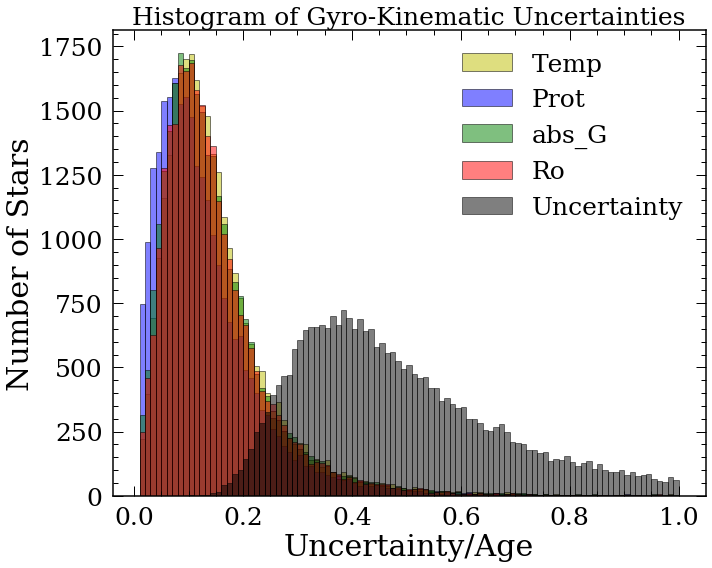

In [46]:
df_ruth=df_ruth.loc[df_ruth['kin_age_temp_err']<2]
df_ruth=df_ruth.loc[df_ruth['kin_age_prot_err']<2]
df_ruth=df_ruth.loc[df_ruth['kin_age_absg_err']<2]
df_ruth=df_ruth.loc[df_ruth['kin_age_ro_err']<2]
df_ruth=df_ruth.loc[df_ruth['kin_age_err']<5]

print('temp_err','prot_err','absg_err','ro_err','total_err')
print(np.median(df_ruth[['kin_age_temp_err']]),np.median(df_ruth[['kin_age_prot_err']]),
      np.median(df_ruth[['kin_age_absg_err']]),np.median(df_ruth[['kin_age_ro_err']]),
     np.median(df_ruth[['kin_age_err']]))
print(np.std(df_ruth[['kin_age_temp_err']].values),np.std(df_ruth[['kin_age_prot_err']].values),
      np.std(df_ruth[['kin_age_absg_err']].values),np.std(df_ruth[['kin_age_ro_err']].values),
     np.std(df_ruth[['kin_age_err']].values))


plt.figure(figsize=(10,8))
bins=np.linspace(0.01,1,100)
plt.hist(df_ruth['kin_age_temp_err'],bins=bins,alpha=0.5,color='y',edgecolor='k',label='Temp')
plt.hist(df_ruth['kin_age_prot_err'],bins=bins,alpha=0.5,color='b',edgecolor='k',label='Prot')
plt.hist(df_ruth['kin_age_absg_err'],bins=bins,alpha=0.5,color='g',edgecolor='k',label='abs_G')
plt.hist(df_ruth['kin_age_ro_err'],bins=bins,alpha=0.5,color='r',edgecolor='k',label='Ro')
plt.hist(df_ruth['kin_age_err'],bins=bins,alpha=0.5,color='k',edgecolor='k',label='Uncertainty')

#plt.yscale('log')
plt.ylabel('Number of Stars')
plt.xlabel('Uncertainty/Age')
plt.title('Histogram of Gyro-Kinematic Uncertainties',fontsize=25)
plt.legend(loc=1)
plt.tight_layout()

plt.savefig('Figures/Kin_age_err.png')

# Compare star numbers in each bin

In [105]:
df_ruth['nostars']=countstars(df_ruth,['color_teffs','Prot_log','abs_G','Ro'],[150.0, 0.14444444444444443, 0.4555555555555556, 0.14444444444444446])



100%|██████████| 31025/31025 [45:20<00:00, 11.40it/s]  


In [271]:
df_isoages=pd.read_table('GKSPCPapTable2.txt',delimiter='&')
df_ruth=pd.merge(df_isoages,df_ruth,left_on='KIC',right_on='KID',how='inner')

In [272]:
df_ruth.to_pickle('df_ruth.pkl')

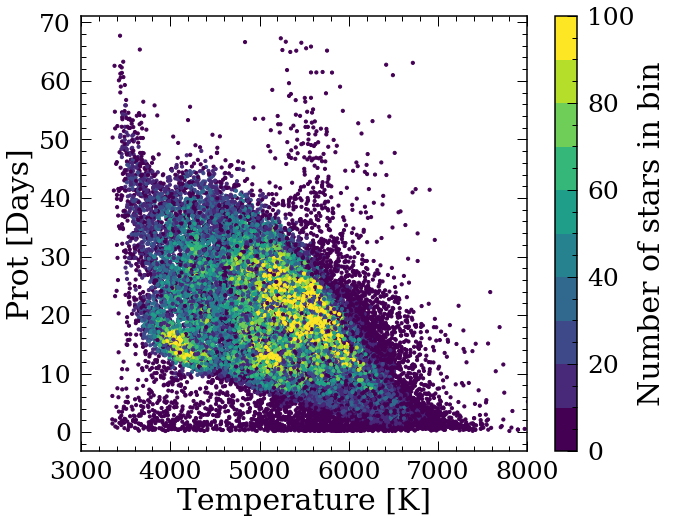

In [112]:
plt.figure(figsize=(10,8))
cm = plt.cm.get_cmap('viridis',10)
plt.scatter(df_ruth['color_teffs'],df_ruth['Prot'],c=df_ruth['nostars'],s=10,vmin=0,vmax=100,cmap=cm,edgecolors=None)

plt.xlabel('Temperature [K]')
plt.gca().invert_xaxis()
plt.ylabel('Prot [Days]')
plt.xlim([3000,8000])
cb=plt.colorbar()

cb.set_label('Number of stars in bin')



# For stars without Prot

In [8]:
df=pd.read_pickle('KinageAllKepler_cut.pkl')

print(np.shape(df))
# drop duplicates
df=df.drop_duplicates(subset ="KID", keep = 'first') 
df=df.reset_index(drop=True)
print(np.shape(df))
df


(154965, 298)
(154965, 298)


solution_id                   designation     source_id  \
0       1.635721e+18  Gaia DR2 2050233807328471424  2.050234e+18   
1       1.635721e+18  Gaia DR2 2050233601176543104  2.050234e+18   
2       1.635721e+18  Gaia DR2 2050230611879323904  2.050231e+18   
3       1.635721e+18  Gaia DR2 2050231848829944320  2.050232e+18   
4       1.635721e+18  Gaia DR2 2050246795316077952  2.050247e+18   
...              ...                           ...           ...   
154960           NaN  Gaia DR2 2107405113436553856  2.107405e+18   
154961           NaN  Gaia DR2 2107653220809356288  2.107653e+18   
154962           NaN  Gaia DR2 2119667691742387456  2.119668e+18   
154963           NaN  Gaia DR2 2134995772891301504  2.134996e+18   
154964           NaN  Gaia DR2 2133234359560358272  2.133234e+18   

        random_index  gaia_ref_epoch          ra  ra_error        dec  \
0       6.894055e+08          2015.5  291.038681  0.035878  36.598031   
1       4.473825e+08          2015.5  291.043057  0.019919  36.593767   
2       1.253667e+09          2015.5  291.095373  0.016886  36.564903   
3       2.980325e+08          2015.5  291.137620  0.019560  36.577344   
4       1.487775e+09          2015.5  290.955123  0.089275  36.689196   
...              ...             ...         ...       ...        ...   
154960           NaN          2015.5  283.626135  0.029896  45.922653   
154961           NaN          2015.5  283.299669  0.274335  47.574221   
154962           NaN          2015.5  282.330377  0.036173  47.724835   
154963           NaN          2015.5  294.320768  0.021501  49.236401   
154964           NaN          2015.5  289.398362  0.018714  51.070181   

        dec_error  parallax  ...  all_vz_new  kin_age_err  nostars    vz_err  \
0        0.047832  1.493916  ...         NaN     5.326506      NaN       NaN   
1        0.027553  2.678194  ...         NaN     4.031776      NaN       NaN   
2        0.022993  1.183652  ...         NaN     1.025695      NaN       NaN   
3        0.025196  1.168913  ...         NaN     2.162486      NaN       NaN   
4        0.104870  0.827378  ...         NaN     1.322065      NaN       NaN   
...           ...       ...  ...         ...          ...      ...       ...   
154960   0.031327  0.984285  ...    2.157172     2.403263      1.0       NaN   
154961   0.328845  3.291184  ...  -12.281180     1.405200      1.0       NaN   
154962   0.040171  5.365343  ...  -10.824418     2.202067      1.0       NaN   
154963   0.028027  0.618519  ...   11.202053     1.966833      1.0  1.385355   
154964   0.019744  0.574945  ...   10.004843     1.224340      1.0       NaN   

        vz_err_all  teff_calc_new    v_b_new  kin_age_mix  kin_age_mix_err  \
0              NaN    5423.970158  -5.179265     6.995510         5.326506   
1              NaN    5477.429540  -6.725869     3.580929         1.480028   
2              NaN    6747.462378  -2.553899     2.362980         1.025695   
3              NaN    5511.526630 -33.700887     5.615880         2.162486   
4              NaN    6314.334967   9.732909     3.612966         1.322065   
...            ...            ...        ...          ...              ...   
154960    5.864866            NaN        NaN    12.602471         4.601025   
154961    6.166740            NaN        NaN     0.087438         5.115815   
154962    6.213702            NaN        NaN     2.184523         1.585579   
154963    1.385355            NaN        NaN     5.037948         2.358682   
154964    5.325346            NaN        NaN     6.755832         6.678102   

        kin_age_err_AVR  
0              4.199332  
1              0.721212  
2              1.070720  
3              3.199727  
4              1.841336  
...                 ...  
154960         2.409380  
154961         0.036140  
154962         2.775214  
154963         1.991481  
154964         6.371147  

[154965 rows x 298 columns]

In [7]:
# get velocity, teff, abs G
df['v_t'],df['v_b']=Astraea.getVs(df)



In [9]:
df_ruth=pd.read_pickle('df_ruth.pkl')

In [13]:
np.mean(df_ruth['Prot']),np.std(df_ruth['Prot'])

(17.751083114813927, 10.524923531240605)

In [9]:
print(np.shape(df))
df=df.loc[df['teff_calc']>3000]
df=df.loc[df['teff_calc']<8000]
print(np.shape(df))

df['Prot_predict']=np.random.normal(17.8, 10.5, len(df))
df['Prot_log']=np.log10(df['Prot_predict'])
df['Ro']=df['Prot_predict']/stardate.convective_overturn_time(df['mass'])


(154965, 298)
(154964, 298)


/Users/lucy/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


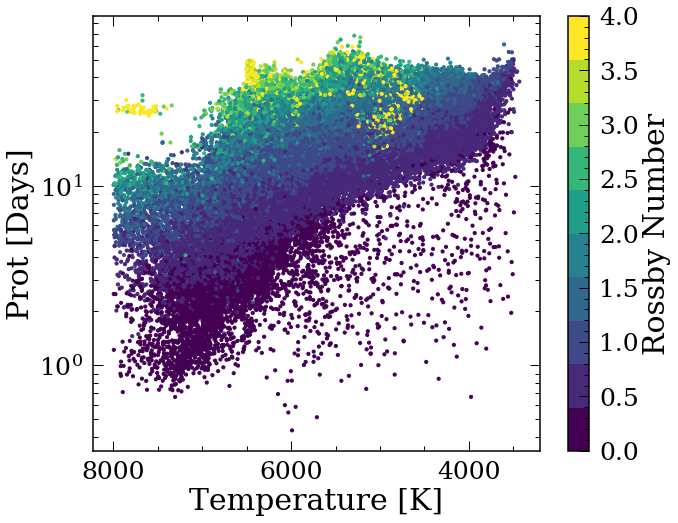

In [55]:
plt.figure(figsize=(10,8))
cm = plt.cm.get_cmap('viridis',10)
plt.scatter(df['teff_calc'],df['Prot_predict'],c=df['Ro'],s=10,vmin=0,vmax=4,cmap=cm,edgecolors=None)

plt.xlabel('Temperature [K]')
plt.gca().invert_xaxis()
plt.yscale('log')
plt.ylabel('Prot [Days]')

cb=plt.colorbar()

cb.set_label('Rossby Number')


In [10]:
# Cut binaries
z=[ 7.43269812e-21,-2.85871860e-16 ,4.37669326e-12,-3.47574268e-08,1.52548746e-04,
   -3.54673368e-01,3.51882114e+02]
p = np.poly1d(z)

In [11]:
print(np.shape(df))
m1=df['abs_G']<p(df['teff_calc'])-0.3
m2=df['teff_calc']<6000
m3=df['abs_G']>4
m=m1&m2&m3
df=df[~m]
#df=df.loc[df['abs_G']>4]
print(np.shape(df))

(154964, 298)
(152323, 298)


In [15]:
# combine rotation periods
df_ruth=pd.read_pickle('df_ruth.pkl')
KIDs_prot=df_ruth['KID'].values
Prots=df_ruth['Prot'].values
Prots_err=df_ruth['Prot_err'].values

df['Prot_mix']=df['Prot_predict']
df['Prot_mix_err']=df['Prot_predict']*0.1
df_ruth['Prot_mix']=df_ruth['Prot']
df_ruth['Prot_mix_err']=df_ruth['Prot_err']

frames = [df, df_ruth]

df=pd.concat(frames).drop_duplicates(subset='KID',keep='first')

prots=df['Prot_mix'].values
prots_err=df['Prot_mix_err'].values
kids=df['KID'].values

for i in trange(len(KIDs_prot)):
    for j in range(len(df)):
        if kids[j] == KIDs_prot[i]:
            prots[j]=Prots[i]
            prots_err[j]=Prots_err[i]

df['Prot_mix']=prots
df['Prot_mix_err']=prots_err





100%|██████████| 30127/30127 [19:51<00:00, 25.28it/s] 


In [59]:
#df.to_pickle('KinageAllKepler_cut.pkl')

In [12]:
df=df.loc[df['teff_calc']<8000]

In [13]:
df=df.loc[df['abs_G']>4]

In [20]:
df

solution_id                   designation     source_id  \
1       1.635721e+18  Gaia DR2 2050233601176543104  2.050234e+18   
3       1.635721e+18  Gaia DR2 2050231848829944320  2.050232e+18   
6       1.635721e+18  Gaia DR2 2050234735047928320  2.050235e+18   
7       1.635721e+18  Gaia DR2 2050236521754360832  2.050237e+18   
9       1.635721e+18  Gaia DR2 2050232329866320512  2.050232e+18   
...              ...                           ...           ...   
154957           NaN  Gaia DR2 2126096295716782080  2.126096e+18   
154958           NaN  Gaia DR2 2078958613025060224  2.078959e+18   
154960           NaN  Gaia DR2 2107405113436553856  2.107405e+18   
154961           NaN  Gaia DR2 2107653220809356288  2.107653e+18   
154962           NaN  Gaia DR2 2119667691742387456  2.119668e+18   

        random_index  gaia_ref_epoch          ra  ra_error        dec  \
1       4.473825e+08          2015.5  291.043057  0.019919  36.593767   
3       2.980325e+08          2015.5  291.137620  0.019560  36.577344   
6       1.565764e+09          2015.5  291.021663  0.011937  36.643648   
7       1.033231e+09          2015.5  291.024101  0.011912  36.695306   
9       1.535619e+09          2015.5  291.128433  0.010596  36.639033   
...              ...             ...         ...       ...        ...   
154957           NaN          2015.5  291.002548  0.017670  43.709606   
154958           NaN          2015.5  296.948031  0.066367  44.566856   
154960           NaN          2015.5  283.626135  0.029896  45.922653   
154961           NaN          2015.5  283.299669  0.274335  47.574221   
154962           NaN          2015.5  282.330377  0.036173  47.724835   

        dec_error  parallax  ...  all_vz_new  kin_age_err  nostars  vz_err  \
1        0.027553  2.678194  ...         NaN     4.031776      NaN     NaN   
3        0.025196  1.168913  ...         NaN     2.162486      NaN     NaN   
6        0.016227  2.050222  ...         NaN     2.219959      NaN     NaN   
7        0.015535  1.771674  ...         NaN     3.845128      NaN     NaN   
9        0.013696  1.681389  ...         NaN     3.164481      NaN     NaN   
...           ...       ...  ...         ...          ...      ...     ...   
154957   0.018383  2.912229  ...    2.901074     1.705512      2.0     NaN   
154958   0.073064  2.116861  ...   -5.189255     2.140758      1.0     NaN   
154960   0.031327  0.984285  ...    2.157172     2.403263      1.0     NaN   
154961   0.328845  3.291184  ...  -12.281180     1.405200      1.0     NaN   
154962   0.040171  5.365343  ...  -10.824418     2.202067      1.0     NaN   

        vz_err_all  teff_calc_new    v_b_new  kin_age_mix  kin_age_mix_err  \
1              NaN    5477.429540  -6.725869     3.580929         1.480028   
3              NaN    5511.526630 -33.700887     5.615880         2.162486   
6              NaN    5116.094281  -7.518859     4.848359         2.219959   
7              NaN    5513.673589  13.417367     8.189182         3.845128   
9              NaN    5769.582304  26.817292    11.591840         3.164481   
...            ...            ...        ...          ...              ...   
154957    4.185319            NaN        NaN     2.055796         2.152149   
154958    3.173234            NaN        NaN     0.864825         1.829908   
154960    5.864866            NaN        NaN    12.602471         4.601025   
154961    6.166740            NaN        NaN     0.087438         5.115815   
154962    6.213702            NaN        NaN     2.184523         1.585579   

        kin_age_err_AVR  
1              0.721212  
3              3.199727  
6              2.664489  
7              5.097253  
9              7.790694  
...                 ...  
154957         0.003703  
154958        -0.000474  
154960         2.409380  
154961         0.036140  
154962         2.775214  

[72839 rows x 298 columns]

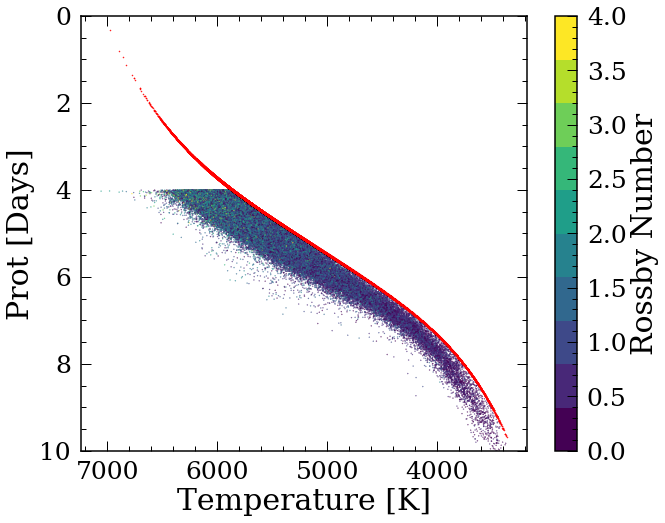

In [14]:
plt.figure(figsize=(10,8))
cm = plt.cm.get_cmap('viridis',10)
plt.scatter(df['teff_calc'],df['abs_G'],c=df['Ro'],s=0.1,vmin=0,vmax=4,cmap=cm,edgecolors=None)
plt.plot(df['teff_calc'],p(df['teff_calc'])-0.3,'r.',markersize=1)
plt.ylim([0,10])
plt.xlabel('Temperature [K]')
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.ylabel('Prot [Days]')

cb=plt.colorbar()

cb.set_label('Rossby Number')


In [64]:
ASstars=pd.merge(df,All_ASstars,left_on='KID',right_on='KID',how='inner')
print(len(ASstars))
#ASstars=ASstars.loc[abs(ASstars['Prot_mix']-ASstars['predict_period'])<5]
print(len(ASstars)) 

df['Prot_log']=np.log10(df['Prot_predict'])
optbin,out_comp,chisq=optimizeBins(df,ASstars,['teff_calc','Prot_log','abs_G','Ro','feh'],
                             [200,0.1,0.01,0.1,0.1],[1000,0.5,0.5,0.5,0.5],df_match_name='ASAge',
                             df_match_name_err='ASAge_err',vz='v_b',min_star=15,bintestNo=5,errVals=True)
"""
df['Prot_log']=np.log10(df['Prot_mix'])
optbin,out_comp,chisq=optimizeBins(df,ASstars,['teff_calc','Prot_log','abs_G','Ro'],
                             [162.5, 0.15, 0.5, 0.2],[162.5, 0.15, 0.5, 0.2],df_match_name='ASAge',
                             df_match_name_err='ASAge_err',vz='v_b',bintestNo=1,errVals=False)
"""                             
                    
""" 
optbin,out_comp,chisq=optimizeBins(df,ASstars,['teff_calc','Prot_log','abs_G','Ro'],
                             [150.0, 0.2333333333333334, 0.4555555555555556, 0.14444444444444446],[150.0, 0.2333333333333334, 0.4555555555555556, 0.14444444444444446],df_match_name='ASAge',
                             min_star=15,max_star=30,df_match_name_err='ASAge_err',vz='v_b',
                             bintestNo=1,errVals=False)

"""

29
29



  0%|          | 1/3125 [00:00<31:49,  1.64it/s]

           KID      ASAge  ASAge_err  kin_age_err    veldisp    kin_age
0    3427720.0   2.230000    0.17000     1.905726  10.461004   2.455876
1    3427720.0   2.330517    0.10935     1.905726  10.461004   2.455876
2    3735871.0   1.834100    0.44565     2.194826  12.285144   3.163445
3    5950854.0   9.359767    0.94630     1.891458  26.052604  10.336878
4    6116048.0   6.230000    0.37000     2.697807  22.367763   8.129648
5    6116048.0   6.474333    1.97805     2.697807  22.367763   8.129648
6    7106245.0   6.770683    0.94570     2.402841  35.512080  16.837657
7    7871531.0   9.150000    0.47000     4.518542  22.023548   7.933466
8    7871531.0   9.360683    0.63170     4.518542  22.023548   7.933466
9    7970740.0  10.841467    1.48585     0.425708   6.518615   1.165868
10   8006161.0   5.040000    0.17000     4.628716  18.037921   5.792942
11   8006161.0   4.653233    0.75495     4.628716  18.037921   5.792942
12   8394589.0   4.141317    0.43185     2.430861  25.652694  10


 10%|▉         | 305/3125 [01:23<12:26,  3.78it/s]


 19%|█▉        | 609/3125 [03:08<14:24,  2.91it/s]


 29%|██▉       | 911/3125 [05:01<13:32,  2.73it/s]


 39%|███▊      | 1209/3125 [06:48<13:20,  2.39it/s]


 48%|████▊     | 1507/3125 [08:32<05:01,  5.37it/s]


 58%|█████▊    | 1803/3125 [10:21<08:01,  2.75it/s]


 67%|██████▋   | 2103/3125 [12:08<06:27,  2.64it/s]


 77%|███████▋  | 2408/3125 [13:59<02:51,  4.18it/s]


 87%|████████▋ | 2726/3125 [15:24<02:12,  3.02it/s]


 97%|█████████▋| 3034/3125 [17:15<00:29,  3.05it/s]


100%|██████████| 3125/3125 [17:54<00:00,  2.91it/s]

 10%|█         | 3/29 [00:00<00:00, 26.15it/s]

[1000.0, 0.2, 0.5, 0.5, 0.30000000000000004]



100%|██████████| 29/29 [00:00<00:00, 44.59it/s]

0     0.0
1     0.0
2     0.0
3     0.0
4     0.0
5     0.0
6     0.0
7     0.0
8     0.0
9     0.0
10    0.0
11    0.0
12    0.0
13    0.0
14    0.0
15    0.0
16    0.0
17    0.0
18    0.0
19    0.0
20    0.0
21    0.0
22    0.0
23    0.0
24    0.0
25    0.0
26    0.0
27    0.0
28    0.0
Name: kin_age, dtype: float64


" \noptbin,out_comp,chisq=optimizeBins(df,ASstars,['teff_calc','Prot_log','abs_G','Ro'],\n                             [150.0, 0.2333333333333334, 0.4555555555555556, 0.14444444444444446],[150.0, 0.2333333333333334, 0.4555555555555556, 0.14444444444444446],df_match_name='ASAge',\n                             min_star=15,max_star=30,df_match_name_err='ASAge_err',vz='v_b',\n                             bintestNo=1,errVals=False)\n\n"

optimized bin size: [1000.0, 0.2, 0.5, 0.5, 0.30000000000000004] . with chisq: 0.5162158991147564


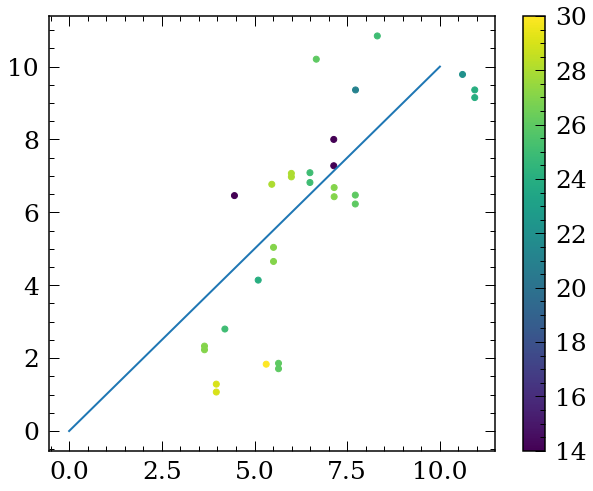

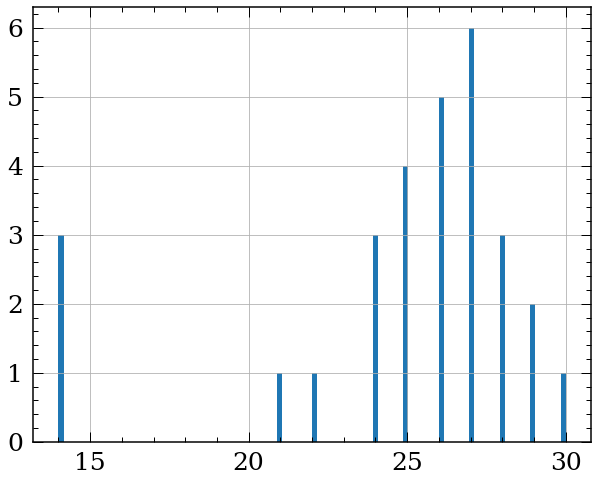

In [65]:
print('optimized bin size:',optbin,'. with chisq:',chisq)
plt.figure(figsize=(10,8))
"""
plt.errorbar(out_comp['kin_age'],out_comp['measure_age'],xerr=out_comp['kin_age_err'],
             yerr=out_comp['measure_age_err'],fmt='ro')
"""
plt.scatter(out_comp['kin_age'],out_comp['measure_age'],c=out_comp['NumbStars'])
cb=plt.colorbar()


plt.plot([0,10],[0,10])

plt.figure(figsize=(10,8))
out_comp['NumbStars'].hist(bins=100)

optimized bin size: [1000.0, 0.2, 0.5, 0.5, 0.30000000000000004] . with chisq: 0.5162158991147564


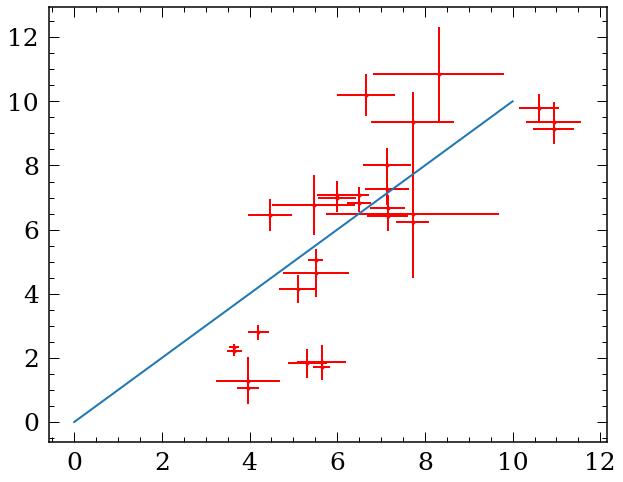

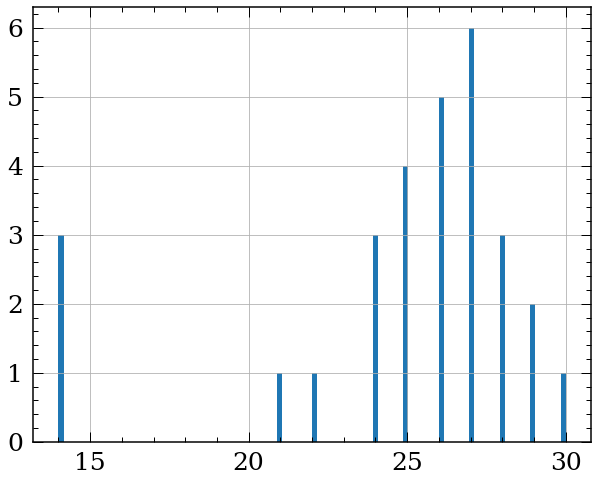

In [66]:
print('optimized bin size:',optbin,'. with chisq:',chisq)
plt.figure(figsize=(10,8))
plt.errorbar(out_comp['kin_age'],out_comp['measure_age'],xerr=out_comp['measure_age_err'],
             yerr=out_comp['measure_age_err'],fmt='r.')

plt.plot([0,10],[0,10])

plt.figure(figsize=(10,8))
out_comp['NumbStars'].hist(bins=100)

In [16]:
#df_ruth['Ro']=df_ruth['Prot']/stardate.convective_overturn_time(df_ruth['mass'])

df_isoages=pd.read_table('GKSPCPapTable2.txt',delimiter='&')
IAcomp=pd.merge(df_isoages,df[[i for i in df.columns if 'iso' not in i]],left_on='KIC',right_on='KID',how='inner')
IAcomp=IAcomp.loc[IAcomp['iso_age']<10]
IAcomp=IAcomp.loc[IAcomp['iso_age_err1']<3]

IAcomp=IAcomp.loc[IAcomp['Ro']<2.08]

In [14]:

optbin,out_comp,chisq=optimizeBins(df,IAcomp,['teff_calc','Prot_log','abs_G','Ro'],
                             [400.0, 0.2, 0.01, 0.30000000000000004],
                                [400.0, 0.2, 0.01, 0.30000000000000004],df_match_name='iso_age',
                             df_match_name_err='iso_age_err1',vz='v_b',bintestNo=1,min_star=15,errVals=True)
"""
optbin,out_comp,chisq=optimizeBins(df_ruth,IAcomp,['color_teffs','Prot_log','abs_G','Ro'],
                             [50.0, 0.1, 0.45, 0.1],[500.0, 0.5, 0.46, 0.5],df_match_name='iso_age',
                             df_match_name_err='iso_age_err1',vz='all_vz',bintestNo=3,errVals=True)
"""
#[150.0, 0.14444444444444443, 0.4555555555555556, 0.14444444444444446]
#[500.0, 0.5, 0.46, 0.5]

  0%|          | 11/70644 [00:00<11:06, 105.96it/s]

              KID  iso_age  iso_age_err1  kin_age_err    veldisp   kin_age
0        757280.0     1.24          0.20     1.025695  11.572466  2.879249
1        891901.0     2.23          0.73     1.322065  17.250027  5.399421
2        892667.0     1.56          0.32     1.958151  14.129726  3.943247
3        892713.0     1.44          0.11     1.594078   7.342223  1.406174
4        892828.0     2.14          0.43     2.419859  15.522693  4.572684
...           ...      ...           ...          ...        ...       ...
70639  12934955.0     2.11          0.57     2.596763   9.508417  2.112973
70640  12935035.0     5.09          0.82     3.103467  15.019647  4.341456
70641  12984000.0     4.44          0.65     1.795412  20.280099  6.967014
70642  12984012.0     3.72          2.70     1.960738  24.664337  9.482667
70643  12984200.0     5.81          1.07     2.629166  23.584655  8.837112

[70309 rows x 6 columns]
[400.0, 0.2, 0.01, 0.30000000000000004]


100%|██████████| 70644/70644 [08:59<00:00, 131.05it/s]

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
70639    0.0
70640    0.0
70641    0.0
70642    0.0
70643    0.0
Name: kin_age, Length: 70644, dtype: float64



/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in log
/Users/lucy/anaconda3/lib/python3.7/site-packages/numpy/lib/polynomial.py:734: RuntimeWarning: invalid value encountered in multiply
  y = y * x + p[i]


"\noptbin,out_comp,chisq=optimizeBins(df_ruth,IAcomp,['color_teffs','Prot_log','abs_G','Ro'],\n                             [50.0, 0.1, 0.45, 0.1],[500.0, 0.5, 0.46, 0.5],df_match_name='iso_age',\n                             df_match_name_err='iso_age_err1',vz='all_vz',bintestNo=3,errVals=True)\n"

optimized bin size: [400.0, 0.2, 0.01, 0.30000000000000004] . with chisq: 2.0065971046837467
5.724922472138551


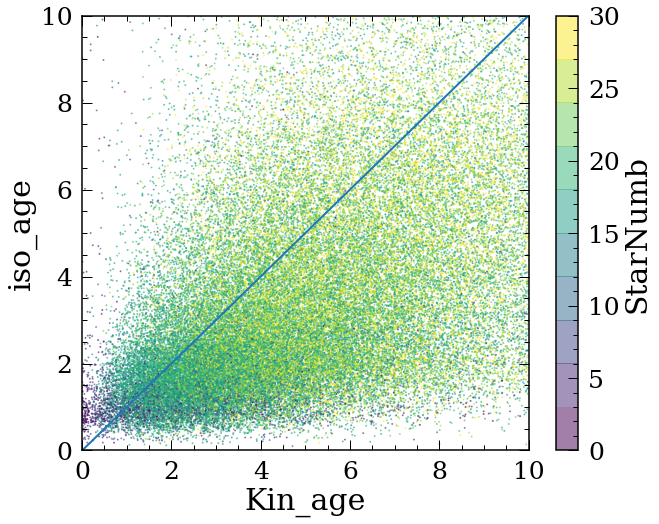

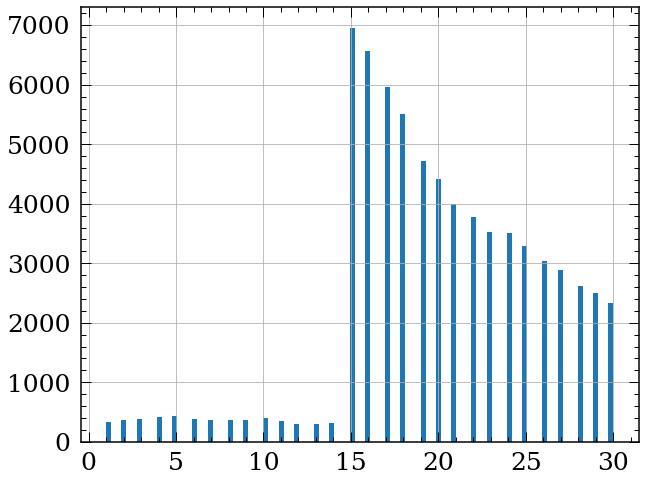

In [15]:
print('optimized bin size:',optbin,'. with chisq:',chisq)
plt.figure(figsize=(10,8))
"""
#plt.errorbar(out_comp['kin_age'],out_comp['measure_age'],yerr=out_comp['measure_age_err'],fmt='r.',alpha=0.1)
plt.plot(out_comp['kin_age'],out_comp['measure_age'],'r.',markersize=1)
"""

cm = plt.cm.get_cmap('viridis',10)
out_comp_plot=out_comp.loc[out_comp['NumbStars']>0].dropna()
out_comp_plot=out_comp_plot.loc[out_comp_plot['NumbStars']<100].dropna()
print(calcChi2(out_comp_plot['kin_age'],out_comp_plot['measure_age'],np.ones(len(out_comp_plot)),out_comp_plot['measure_age_err']))
plt.scatter(out_comp_plot['kin_age'],out_comp_plot['measure_age'],c=out_comp_plot['NumbStars'],cmap=cm,vmin=0,vmax=30,s=1,alpha=0.5)
cb=plt.colorbar()
cb.set_label('StarNumb')

plt.plot([0,10],[0,10])
plt.xlabel('Kin_age')
plt.ylabel('iso_age')
plt.xlim([0,10])
plt.ylim([0,10])

plt.figure(figsize=(10,8))
out_comp['NumbStars'].hist(bins=100)

# 7

In [17]:

#df['vel_dis'],df['kin_age']=getkinAges(df,['teff_calc','Prot_log','abs_G'],[350.0, 0.5, 0.17])
#df['vel_dis'],df['kin_age']=getkinAges(df,['teff_calc','Prot_log','abs_G'],[200.0, 0.4, 0.5])
df['Prot_log']=np.log10(df['Prot_mix'])
df['vel_dis'],df['kin_age']=getkinAges(df,['teff_calc','Prot_log','abs_G','Ro'],
                                       [162.5, 0.15, 0.5, 0.2],
                                       vz='v_b',min_star=15,max_star=30)

"""\
ages=getkinAges_err(df_ruth,['color_teffs','Prot_log','abs_G','Ro'],['teff_err1','Prot_err','abs_G_err','Ro_err'],
                    [150.0, 0.23333333333333334, 0.4555555555555556, 0.14444444444444446],min_star=15,max_star=30,
                    sampsize=50,vz='all_vz',vz_err='vz_err_all')
df_ruth['kin_age_err']=[np.std(pd.Series(ages[i,:]).dropna()) for i in range(len(df_ruth))]

"""


"""
testing=10000
px_s=getErr(df['parallax'].values,df['parallax_error'].values,testing)
pmra_s=getErr(df['pmra'].values,df['pmra_error'].values,testing)
pmdec_s=getErr(df['pmdec'].values,df['pmdec_error'].values,testing)
ra_s=getErr(df['ra'].values,df['ra_error'].values,testing)
dec_s=getErr(df['dec'].values,df['dec_error'].values,testing)

"""

/Users/lucy/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
  0%|          | 36/82234 [00:00<07:57, 171.98it/s]/Users/lucy/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/lucy/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 82234/82234 [08:31<00:00, 160.66it/s]
/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in log
/Users/lucy/anaconda3/lib/python3.7/site-packages/numpy/lib/polynomial.py:734: RuntimeWarning: invalid value encountered in multiply
  y = y * x + p[i]


89229


"\ntesting=10000\npx_s=getErr(df['parallax'].values,df['parallax_error'].values,testing)\npmra_s=getErr(df['pmra'].values,df['pmra_error'].values,testing)\npmdec_s=getErr(df['pmdec'].values,df['pmdec_error'].values,testing)\nra_s=getErr(df['ra'].values,df['ra_error'].values,testing)\ndec_s=getErr(df['dec'].values,df['dec_error'].values,testing)\n\n"

In [18]:
print(np.shape(df))
df=df.dropna(subset=['kin_age']).reset_index(drop=True)
print(np.shape(df))
#df.to_pickle('KinageAllKepler_cut_redo.pkl')

(82234, 303)
(79712, 303)


In [4]:
df=pd.read_pickle('KinageAllKepler_cut_random.pkl')

In [6]:
list(df.columns)

['solution_id',
 'designation',
 'source_id',
 'random_index',
 'gaia_ref_epoch',
 'ra',
 'ra_error',
 'dec',
 'dec_error',
 'parallax',
 'parallax_error',
 'parallax_over_error',
 'pmra',
 'pmra_error',
 'pmdec',
 'pmdec_error',
 'ra_dec_corr',
 'ra_parallax_corr',
 'ra_pmra_corr',
 'ra_pmdec_corr',
 'dec_parallax_corr',
 'dec_pmra_corr',
 'dec_pmdec_corr',
 'parallax_pmra_corr',
 'parallax_pmdec_corr',
 'pmra_pmdec_corr',
 'astrometric_n_obs_al',
 'astrometric_n_obs_ac',
 'astrometric_n_good_obs_al',
 'astrometric_n_bad_obs_al',
 'astrometric_gof_al',
 'astrometric_chi2_al',
 'astrometric_excess_noise',
 'astrometric_excess_noise_sig',
 'astrometric_params_solved',
 'astrometric_primary_flag',
 'astrometric_weight_al',
 'astrometric_pseudo_colour',
 'astrometric_pseudo_colour_error',
 'mean_varpi_factor_al',
 'astrometric_matched_observations',
 'visibility_periods_used',
 'astrometric_sigma5d_max',
 'frame_rotator_object_type',
 'matched_observations',
 'duplicated_source',
 'phot_g

In [ ]:
df['Ro']=df['Prot']/stardate.convective_overturn_time(df['mass'])

In [19]:
df.to_pickle('KinageAllKepler_cut_random.pkl')

In [28]:
df=GetParaErrors(df)

KeyboardInterrupt: 

In [22]:
df['Prot_mix_err']

0          2.048362
1          0.367000
2          0.286635
3          1.522762
4          0.761780
            ...    
158101    18.169000
158102    28.304000
158103    25.762000
158104     0.612000
158105    45.957000
Name: Prot_mix_err, Length: 158106, dtype: float64

(158176, 295)
(155965, 295)


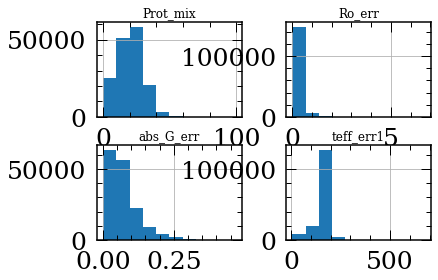

In [48]:
#df.to_pickle('KinageAllKepler_cut.pkl')
df=pd.read_pickle('KinageAllKepler_cut.pkl')
df['Ro_err']=abs(df['Ro_err'])
print(np.shape(df))
df[['teff_err1','Prot_mix','abs_G_err','Ro_err']].hist()
df=df.dropna(subset=['teff_err1','Prot_mix_err','abs_G_err','Ro_err'])
print(np.shape(df))

In [46]:
df['Ro_err'].dropna()

0        0.503053
1        0.007083
2        0.074088
3        0.077790
4        0.132515
           ...   
27841    0.006385
28304    0.013849
28444    0.000953
28663    0.097719
29589    0.023160
Name: Ro_err, Length: 155965, dtype: float64

In [ ]:
# calculate errors 

ages=getkinAges_err(df,['teff_calc','Prot_log','abs_G','Ro'],['teff_err1','Prot_err','abs_G_err','Ro_err'],[162.5, 0.15, 0.5, 0.2],min_star=15,max_star=30,vz='v_b')
df['kin_age_err']=[np.std(pd.Series(ages[i,:]).dropna()) for i in range(len(df_ruth))]




In [26]:
#df=pd.read_pickle('KinageAllKepler_cut_redo.pkl')
df=df.loc[df['abs_G']>4]
    
def compstars(df,err=True,ave=False,IOfile=False):
    # AS stars
    AScomp=pd.merge(All_ASstars,df,left_on='KID',right_on='KID',how='inner')
    print(np.shape(AScomp))
    AScomp=AScomp.loc[abs(AScomp['predict_period']-AScomp['Prot_predict'])<5]
    print(np.shape(AScomp))
    
    # clusters
    df_culsters=pd.read_pickle('clusters.pkl')
    df_CLUSTERS=pd.merge(df_culsters,df[['KID','kin_age']],left_on='KID',right_on='KID',how='inner')
    ages=[]
    ages_err=[]
    ages_cluster=[]
    ages_cluster_err=[]
    for name in df_CLUSTERS.CLUSTER.unique():
        dfProt_cluster_single=df_CLUSTERS.loc[df_CLUSTERS['CLUSTER']==name].reset_index(drop=True)
    
        mask1=dfProt_cluster_single['PROT']<3
        mask2=dfProt_cluster_single['TEFF']>6000
    
        mask=mask1&mask2
    
        mask1=dfProt_cluster_single['PROT']<5
        mask2=dfProt_cluster_single['TEFF']>5000
        mask3=dfProt_cluster_single['TEFF']<6000
    
        mask=mask|(mask1&mask2&mask3)
    
        mask1=dfProt_cluster_single['PROT']<10
        mask2=dfProt_cluster_single['TEFF']>4200
        mask3=dfProt_cluster_single['TEFF']<5000
    
        mask=mask|(mask1&mask2&mask3)
    
        mask1=dfProt_cluster_single['PROT']<20
        mask2=dfProt_cluster_single['TEFF']>2000
        mask3=dfProt_cluster_single['TEFF']<4200
    
        mask=mask|(mask1&mask2&mask3)
    
        dfProt_cluster_single=dfProt_cluster_single[~mask]
        if len(dfProt_cluster_single)==0:
            continue
        print(name)
        
        ages.append(np.mean(dfProt_cluster_single['kin_age']))
        ages_err.append(np.std(dfProt_cluster_single['kin_age']))
        ages_cluster.append(dfProt_cluster_single['AGE'].values[0]/1000)
        ages_cluster_err.append(dfProt_cluster_single['AGE_err'].values[0]/1000)
    
    # Isochrone stars
    df_isoages=pd.read_table('GKSPCPapTable2.txt',delimiter='&')
    IAcomp=pd.merge(df_isoages,df[[i for i in df.columns if 'iso' not in i]],left_on='KIC',right_on='KID',how='inner')

    if ave:
        IAcomp['vel_dis'],IAcomp['iso_age_ave']=getAveAges(IAcomp,['teff_calc','Prot_log','abs_G','Ro'],[125.0, 0.05, 0.45, 0.15],vz='v_b')
    
    if IOfile:
        IAcomp=np.load('XD_all.npy')
    else:
        IAcomp=IAcomp.loc[IAcomp['iso_age']<10]
        IAcomp=IAcomp.loc[IAcomp['iso_age_err1']<3]
        IAcomp=IAcomp.loc[IAcomp['Ro']<2.08]
        
    if ave:
        IAcomp.to_pickle('IsoStars_all.pkl')
        
        
    # WD ages
    WDKID=[12456401,11075611,5342558,7732146,11822514]
    WDage=[3.59,3.64,3.59,3.64,3.59]
    WDage_err=[4.92,3.05,3.59,3.64,3.59]
    df_WDage=pd.DataFrame(np.array((WDKID,WDage,WDage_err)).T,columns=['KID','WDage','WDage_err'])
    
    if err:
        df_WDcomp=pd.merge(df_WDage,df[['KID','kin_age','kin_age_err']],left_on='KID',right_on='KID',how='inner')
    else:
        df_WDcomp=pd.merge(df_WDage,df[['KID','kin_age']],left_on='KID',right_on='KID',how='inner')
    print(df_WDcomp)
    plt.figure(figsize=(10,8))
    if err:
        plt.errorbar(AScomp['ASAge'],AScomp['kin_age'],fmt='go',label='AS ages')
        plt.errorbar(AScomp['ASAge'],AScomp['kin_age'],xerr=AScomp['ASAge_err'],yerr=AScomp['kin_age_err'],fmt='go',label='AS ages',alpha=0.5)
        plt.errorbar(df_WDcomp['WDage'],df_WDcomp['kin_age'],xerr=df_WDcomp['WDage_err'],yerr=df_WDcomp['kin_age_err'],fmt='bo',label='WD ages')
    else:
        plt.errorbar(AScomp['ASAge'],AScomp['kin_age'],xerr=AScomp['ASAge_err'],fmt='go',label='AS ages')
        plt.errorbar(df_WDcomp['WDage'],df_WDcomp['kin_age'],xerr=df_WDcomp['WDage_err'],fmt='bo',label='WD ages')
    if IOfile:
        plt.plot(IAcomp[:, 0], IAcomp[:, 1],'k.',markersize=4,label='Iso ages')
    elif ave:
        plt.plot(IAcomp['iso_age_ave'],IAcomp['kin_age'],'k.',markersize=1,label='Iso ages')
    else:
        plt.plot(IAcomp['iso_age'],IAcomp['kin_age'],'k.',markersize=1,label='Iso ages')
    
    
    plt.errorbar(ages_cluster,ages,xerr=ages_cluster_err,yerr=ages_err,fmt='ro',label='Clusters')
    plt.plot([0,15],[0,15])
    #plt.yscale('log')
    #plt.xscale('log')
    plt.xlim([0,10])
    plt.ylim([0,10])
    plt.legend()
    plt.ylabel('Kinematic ages')
    plt.xlabel('Measured ages')
    #plt.savefig('FinalComp_predict.png')
    

(27, 440)
(6, 440)
Pleiades
Praesepe
Hyades
NGC_752
NGC_6811
Ruprecht_147
NGC_6819
          KID  WDage  WDage_err   kin_age  kin_age_err
0  12456401.0   3.59       4.92  1.192913     3.494174
1  11075611.0   3.64       3.05  9.521275     2.917989


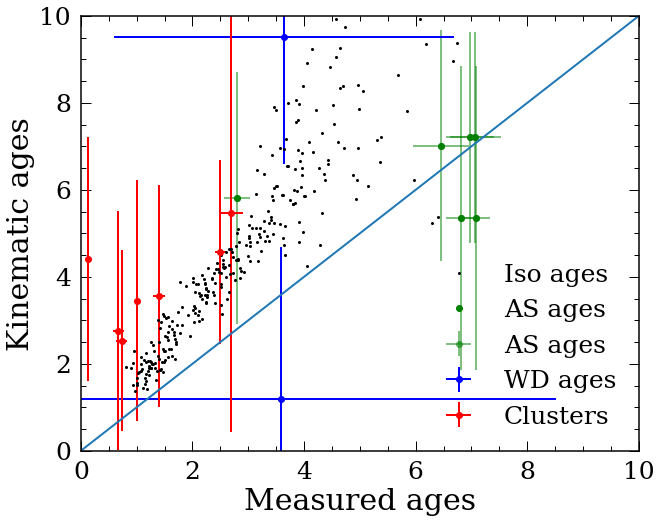

In [29]:
#df_ruth['kin_age']=df_ruth['age']
#df=pd.merge(df_isoages,df,left_on='KIC',right_on='KID',how='inner')
#df.to_pickle('KinageAllKepler.pkl')
compstars(df,ave=False,err=True,IOfile=True)
plt.savefig('Figures/FinalComp_predict_random.png')

In [7]:
# correct for bias

df=pd.read_pickle('KinageAllKepler_cut.pkl')
    
def compstars(df,err=True,ave=False):
    IAcomp=np.load('XD_all.npy')
    z = np.polyfit(IAcomp[:, 0], IAcomp[:, 1],1)
    
    IAcomp[:, 1]=(IAcomp[:, 1]-z[1])/z[0]
    
    df['kin_age']=(df['kin_age']-z[1])/z[0]
    
    
    # AS stars
    AScomp=pd.merge(All_ASstars,df,left_on='KID',right_on='KID',how='inner')
    print(np.shape(AScomp))
    AScomp=AScomp.loc[abs(AScomp['predict_period']-AScomp['Prot_predict'])<5]
    print(np.shape(AScomp))
    
    # clusters
    df_culsters=pd.read_pickle('clusters.pkl')
    df_CLUSTERS=pd.merge(df_culsters,df[['KID','kin_age']],left_on='KID',right_on='KID',how='inner')
    ages=[]
    ages_err=[]
    ages_cluster=[]
    ages_cluster_err=[]
    for name in df_CLUSTERS.CLUSTER.unique():
        dfProt_cluster_single=df_CLUSTERS.loc[df_CLUSTERS['CLUSTER']==name].reset_index(drop=True)
    
        mask1=dfProt_cluster_single['PROT']<3
        mask2=dfProt_cluster_single['TEFF']>6000
    
        mask=mask1&mask2
    
        mask1=dfProt_cluster_single['PROT']<5
        mask2=dfProt_cluster_single['TEFF']>5000
        mask3=dfProt_cluster_single['TEFF']<6000
    
        mask=mask|(mask1&mask2&mask3)
    
        mask1=dfProt_cluster_single['PROT']<10
        mask2=dfProt_cluster_single['TEFF']>4200
        mask3=dfProt_cluster_single['TEFF']<5000
    
        mask=mask|(mask1&mask2&mask3)
    
        mask1=dfProt_cluster_single['PROT']<20
        mask2=dfProt_cluster_single['TEFF']>2000
        mask3=dfProt_cluster_single['TEFF']<4200
    
        mask=mask|(mask1&mask2&mask3)
    
        dfProt_cluster_single=dfProt_cluster_single[~mask]
        if len(dfProt_cluster_single)==0:
            continue
        print(name)
        
        ages.append(np.mean(dfProt_cluster_single['kin_age']))
        ages_err.append(np.std(dfProt_cluster_single['kin_age']))
        ages_cluster.append(dfProt_cluster_single['AGE'].values[0]/1000)
        ages_cluster_err.append(dfProt_cluster_single['AGE_err'].values[0]/1000)
        
        
        
    # WD ages
    WDKID=[12456401,11075611,5342558,7732146,11822514]
    WDage=[3.59,3.64,3.59,3.64,3.59]
    WDage_err=[4.92,3.05,3.59,3.64,3.59]
    df_WDage=pd.DataFrame(np.array((WDKID,WDage,WDage_err)).T,columns=['KID','WDage','WDage_err'])
    
    
    df_WDcomp=pd.merge(df_WDage,df[['KID','kin_age','kin_age_err']],left_on='KID',right_on='KID',how='inner')
    
    
    plt.figure(figsize=(10,8))
    plt.plot(IAcomp[:, 0], IAcomp[:, 1],'k.',markersize=4,label='Iso ages')
    plt.errorbar(AScomp['ASAge'],AScomp['kin_age'],fmt='go',label='AS ages')
    plt.errorbar(AScomp['ASAge'],AScomp['kin_age'],xerr=AScomp['ASAge_err'],yerr=AScomp['kin_age_err'],fmt='go',label='AS ages',alpha=0.5)
    plt.errorbar(df_WDcomp['WDage'],df_WDcomp['kin_age'],xerr=df_WDcomp['WDage_err'],yerr=df_WDcomp['kin_age_err'],fmt='bo',label='WD ages')
    plt.errorbar(ages_cluster,ages,xerr=ages_cluster_err,yerr=ages_err,fmt='ro',label='Clusters')
    plt.plot([0,10],[0,10])
    #plt.yscale('log')
    #plt.xscale('log')
    plt.xlim([0,10])
    plt.ylim([0,10])
    plt.legend()
    plt.ylabel('Kinematic ages')
    plt.xlabel('Measured ages')
    #plt.savefig('FinalComp_predict.png')
    return df['kin_age']
    

In [3]:
#df_ruth['kin_age']=df_ruth['age']
#df=pd.merge(df_isoages,df,left_on='KIC',right_on='KID',how='inner')
#df.to_pickle('KinageAllKepler.pkl')
df['kin_age']=compstars(df,ave=False,err=True)
#plt.savefig('Figures/FinalComp_predict.png')

NameError: name 'All_ASstars' is not defined

In [17]:
df1=pd.read_pickle('KeplerAge_correct.pkl')
df2=pd.read_pickle('KinageAllKepler_cut.pkl')

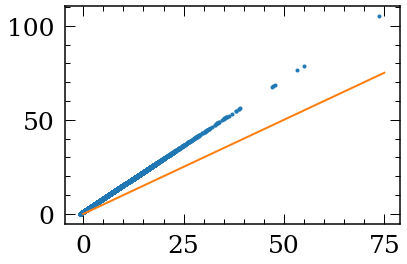

In [22]:
plt.plot(df1['kin_age'],df2['kin_age'],'.')
plt.plot([0,75],[0,75])

In [52]:
TrainF_reg_nolc=['abs_G','mass','teff_calc', 'bp_g', 'lum_val', 'v_t', 'phot_g_mean_flux_over_error', 'v_b', 'radius_val', 'b']


In [55]:
regr, regr_outs = Astraea.RFregressor(df_ruth, TrainF_reg_nolc,
                                      target_var='kin_age', target_var_err='kin_age_err', n_estimators=60)

Simpliest example:
 regr,regr_outs = RFregressor(df,testF)

Fraction of data used to train: 0.8
# of Features attempt to train: 10
Features attempt to train: ['abs_G', 'mass', 'teff_calc', 'bp_g', 'lum_val', 'v_t', 'phot_g_mean_flux_over_error', 'v_b', 'radius_val', 'b']
28797 stars in dataframe!
Missing 479 stars from null values in data!

28318 total stars used for RF!
22654 training stars!
Finished training! Making predictions!
Finished predicting! Calculating statistics!
Median Relative Error is: 0.31951060087002214
Average chi^2 is: 6.801123716696536
Finished!


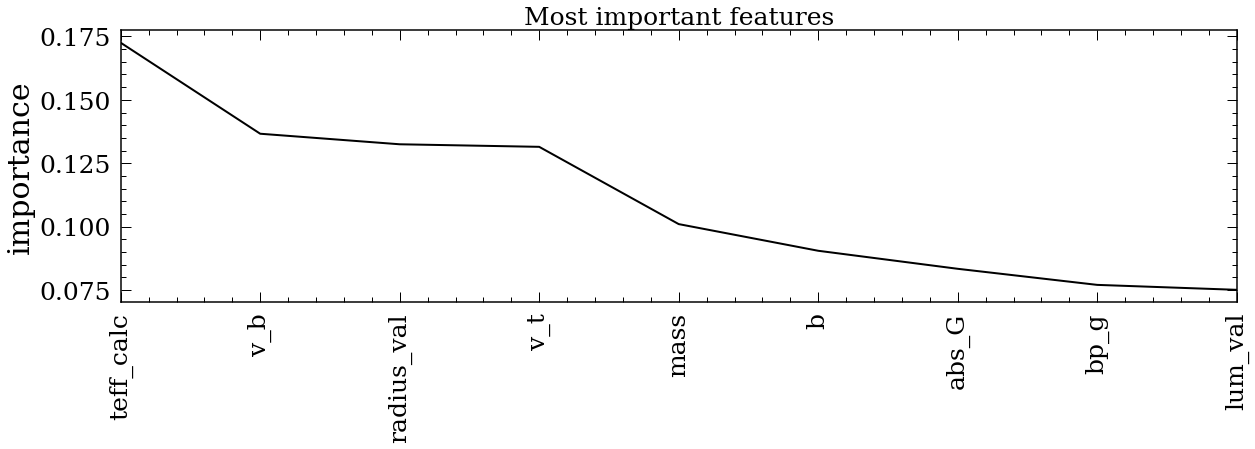

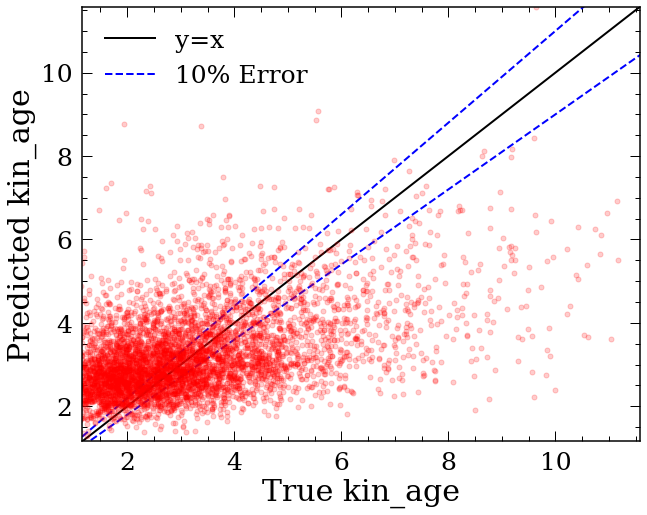

In [56]:
Astraea.plot_result(regr_outs['actrualF'], regr_outs['importance'], regr_outs['prediction'],
                    regr_outs['y_test'], labelName='kin_age', MS=10)

# Compare to 2018 paper

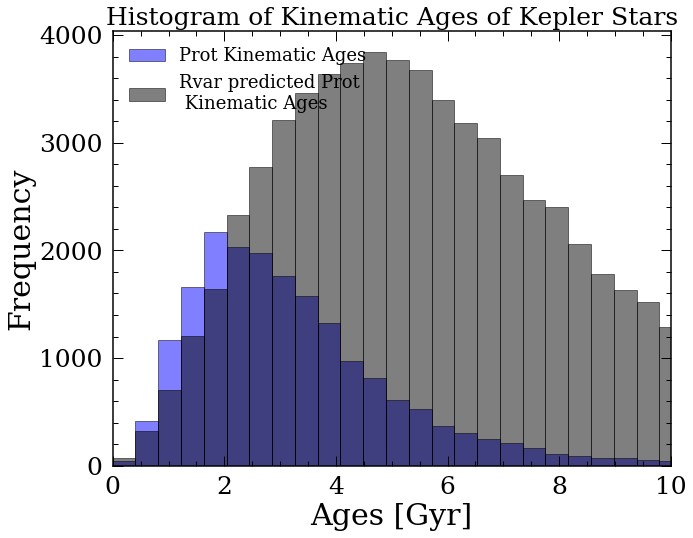

In [79]:
df_temp=df.loc[df['teff_calc']>5500]
df_temp=df_temp.loc[df_temp['teff_calc']<6500]
df_temp=df_temp.loc[df_temp['logg']>4]
#print(len(df_temp))
df_temp=df_temp.loc[df_temp['Ro']<1.7]
#print(len(df_temp))

df_ruth_temp=df_ruth.loc[df['teff_calc']>5500]
df_ruth_temp=df_ruth_temp.loc[df_ruth_temp['teff_calc']<6500]
df_ruth_temp=df_ruth_temp.loc[df_ruth_temp['logg']>4]
#df_ruth_temp=df_ruth_temp.loc[df_ruth_temp['Ro']<2.06]

plt.figure(figsize=(10,8))
bins=np.linspace(0,20,50)
plt.hist(df_ruth_temp['kin_age'],bins=bins,alpha=0.5,color='b',edgecolor='k',label='Prot Kinematic Ages')
plt.hist(df_temp['kin_age'],bins=bins,alpha=0.5,color='k',edgecolor='k',
         label='Rvar predicted Prot\n Kinematic Ages')

#plt.yscale('log')
plt.xlim([0,10])
plt.ylabel('Frequency')
plt.xlabel('Ages [Gyr]')
plt.title('Histogram of Kinematic Ages of Kepler Stars',fontsize=25)
plt.legend(fontsize=18,loc=2)
#plt.savefig('AgesHisto.png')

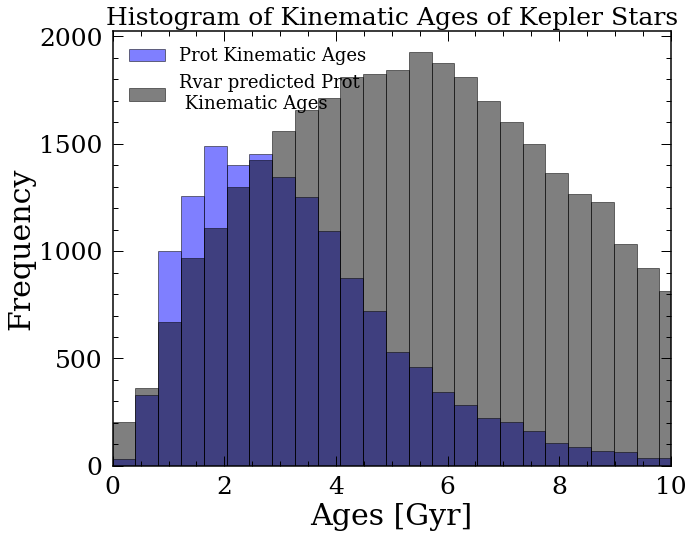

In [71]:
df_temp=df.loc[df['teff_calc']>4500]
df_temp=df_temp.loc[df_temp['teff_calc']<5500]

df_ruth_temp=df_ruth.loc[df['teff_calc']>4500]
df_ruth_temp=df_ruth_temp.loc[df_ruth_temp['teff_calc']<5500]

plt.figure(figsize=(10,8))
bins=np.linspace(0,20,50)
plt.hist(df_ruth_temp['kin_age'],bins=bins,alpha=0.5,color='b',edgecolor='k',label='Prot Kinematic Ages')
plt.hist(df_temp['kin_age'],bins=bins,alpha=0.5,color='k',edgecolor='k',
         label='Rvar predicted Prot\n Kinematic Ages')

#plt.yscale('log')
plt.xlim([0,10])
plt.ylabel('Frequency')
plt.xlabel('Ages [Gyr]')
plt.title('Histogram of Kinematic Ages of Kepler Stars',fontsize=25)
plt.legend(fontsize=18,loc=2)
#plt.savefig('AgesHisto.png')

# Compare parameters cut giants and do again

(array([2.4420e+03, 7.2460e+03, 2.7884e+04, 5.0516e+04, 3.7640e+04,
        2.0006e+04, 6.4030e+03, 2.1880e+03, 6.1300e+02, 5.0000e+01]),
 array([-0.18720284,  0.92176965,  2.03074215,  3.13971464,  4.24868714,
         5.35765963,  6.46663213,  7.57560463,  8.68457712,  9.79354962,
        10.90252211]),
 <a list of 10 Patch objects>)

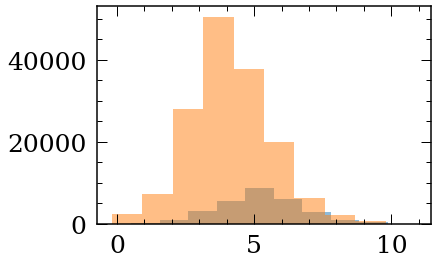

In [102]:
plt.hist(df_ruth['abs_G'],alpha=0.5,bins=10)
plt.hist(df['abs_G'],alpha=0.5,bins=10)


154988
75493


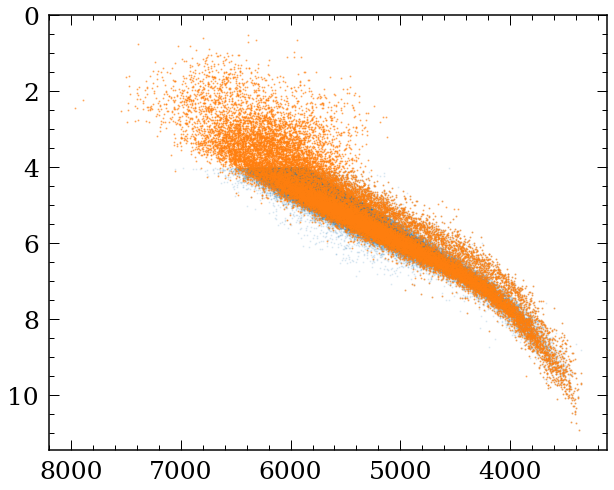

In [133]:

m1=df['teff_calc']<5500
m2=df['abs_G']<4
m3=df['teff_calc']>7500
#m=(m1&m2)|m3
m=df['abs_G']<4

print(len(df))
df_cut=df[~m]
print(len(df_cut))

plt.figure(figsize=(10,8))
#plt.scatter(df['teff_calc'],df['abs_G'],alpha=0.1,s=1)
plt.scatter(df_cut['teff_calc'],df_cut['abs_G'],alpha=0.1,s=1)
plt.scatter(df_ruth['color_teffs'],df_ruth['abs_G'],alpha=0.5,s=1)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()



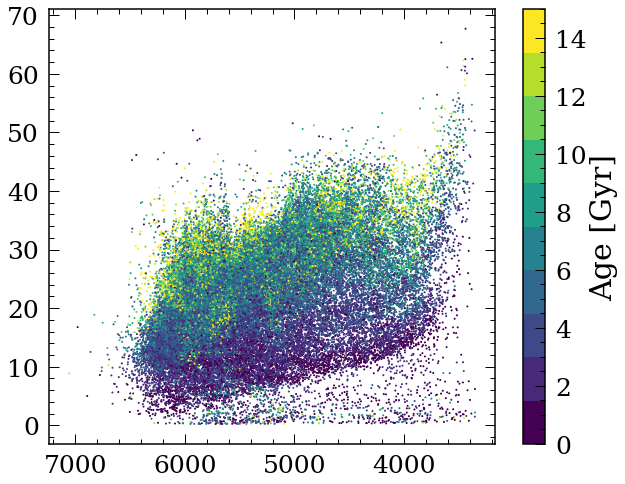

In [128]:
plt.figure(figsize=(10,8))
cm = plt.cm.get_cmap('viridis',10)
plt.scatter(df_cut['teff_calc'],df_cut['Prot_mix'],c=df_cut['kin_age'],s=1,vmin=0,vmax=15,cmap=cm)
cb=plt.colorbar()
cb.set_label('Age [Gyr]')
plt.gca().invert_xaxis()


In [26]:
#df_ruth['kin_age']=df_ruth['age']
#df=pd.merge(df_isoages,df,left_on='KIC',right_on='KID',how='inner')
#df.to_pickle('KinageAllKepler.pkl')
compstars(df_cut,ave=False,err=True,IOfile=False)


NameError: name 'df_cut' is not defined

In [139]:
ASstars=pd.merge(df,All_ASstars,left_on='KID',right_on='KID',how='inner')
print(len(ASstars))
ASstars=ASstars.loc[abs(ASstars['Prot_mix']-ASstars['predict_period'])<5]
print(len(ASstars)) 

optbin,out_comp,chisq=optimizeBins(df_cut,ASstars,['teff_calc','Prot_log','abs_G','Ro'],
                             [50,0.05,0.1,0.1],[500,0.5,0.5,0.5],df_match_name='ASAge',
                             df_match_name_err='ASAge_err',vz='v_b',bintestNo=10,errVals=True)
"""
df['Prot_log']=np.log10(df['Prot_mix'])
optbin,out_comp,chisq=optimizeBins(df,ASstars,['teff_calc','Prot_log','abs_G','Ro'],
                             [162.5, 0.15, 0.5, 0.2],[162.5, 0.15, 0.5, 0.2],df_match_name='ASAge',
                             df_match_name_err='ASAge_err',vz='v_b',bintestNo=1,errVals=False)
"""                             
                    
""" 
optbin,out_comp,chisq=optimizeBins(df,ASstars,['teff_calc','Prot_log','abs_G','Ro'],
                             [150.0, 0.2333333333333334, 0.4555555555555556, 0.14444444444444446],[150.0, 0.2333333333333334, 0.4555555555555556, 0.14444444444444446],df_match_name='ASAge',
                             min_star=15,max_star=30,df_match_name_err='ASAge_err',vz='v_b',
                             bintestNo=1,errVals=False)

"""

81
44


  0%|          | 13/10000 [00:00<03:07, 53.31it/s]

           KID     ASAge  ASAge_err  kin_age_err    veldisp   kin_age
0    3427720.0  2.230000    0.17000     1.905726  23.363566  8.706980
1    3427720.0  2.330517    0.10935     1.905726  23.363566  8.706980
2    3735871.0  1.834100    0.44565     2.194826  13.583064  3.705637
3    6116048.0  6.230000    0.37000     2.697807  16.901876  5.228773
4    8394589.0  4.141317    0.43185     2.430861  14.915702  4.294226
5    9139151.0  1.710000    0.19000     4.308795   7.781047  1.540808
6    9139151.0  1.859100    0.55440     4.308795   7.781047  1.540808
7    9410862.0  6.460550    0.50220     2.651403  17.202044  5.375783
8   10079226.0  2.799083    0.23455     2.897359  11.432771  2.824694
9   10644253.0  1.070000    0.25000     3.431857  15.246319  4.445105
10  10644253.0  1.287300    0.72545     3.431857  15.246319  4.445105


100%|██████████| 11/11 [00:00<00:00, 182.59it/s]


[450.0, 0.05, 0.23333333333333334, 0.14444444444444446]
0     0.0
1     0.0
2     0.0
3     0.0
4     0.0
5     0.0
6     0.0
7     0.0
8     0.0
9     0.0
10    0.0
Name: kin_age, dtype: float64


" \noptbin,out_comp,chisq=optimizeBins(df,ASstars,['teff_calc','Prot_log','abs_G','Ro'],\n                             [150.0, 0.2333333333333334, 0.4555555555555556, 0.14444444444444446],[150.0, 0.2333333333333334, 0.4555555555555556, 0.14444444444444446],df_match_name='ASAge',\n                             min_star=15,max_star=30,df_match_name_err='ASAge_err',vz='v_b',\n                             bintestNo=1,errVals=False)\n\n"

optimized bin size: [450.0, 0.05, 0.23333333333333334, 0.14444444444444446] . with chisq: 0.30373822805612555


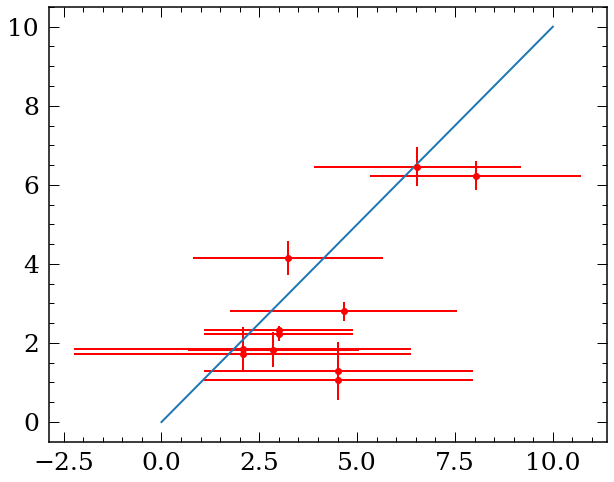

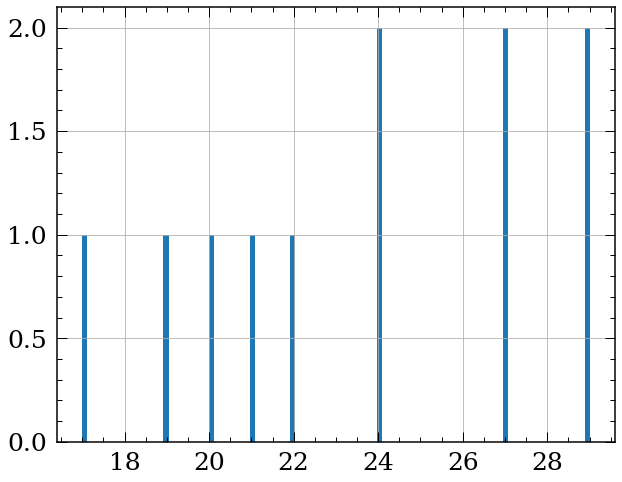

In [142]:
print('optimized bin size:',optbin,'. with chisq:',chisq)
plt.figure(figsize=(10,8))
plt.errorbar(out_comp['kin_age'],out_comp['measure_age'],xerr=out_comp['kin_age_err'],
             yerr=out_comp['measure_age_err'],fmt='ro')

plt.plot([0,10],[0,10])

plt.figure(figsize=(10,8))
out_comp['NumbStars'].hist(bins=100)

In [145]:
#df_ruth['Ro']=df_ruth['Prot']/stardate.convective_overturn_time(df_ruth['mass'])

df_isoages=pd.read_table('GKSPCPapTable2.txt',delimiter='&')
IAcomp=pd.merge(df_isoages,df_cut[[i for i in df_cut.columns if 'iso' not in i]],left_on='KIC',right_on='KID',how='inner')
IAcomp=IAcomp.loc[IAcomp['iso_age']<10]
IAcomp=IAcomp.loc[IAcomp['iso_age_err1']<3]

IAcomp=IAcomp.loc[IAcomp['Ro']<2.08]

In [176]:

optbin,out_comp,chisq=optimizeBins(df_cut,IAcomp,['teff_calc','Prot_log','abs_G','Ro'],
                             [450.0, 0.05, 0.23333333333333334, 0.14444444444444446],
                            [450.0, 0.05, 0.23333333333333334, 0.14444444444444446],df_match_name='iso_age',
                                   min_star=15,max_star=30,
                             df_match_name_err='iso_age_err1',vz='v_b',bintestNo=1,errVals=True)
"""
optbin,out_comp,chisq=optimizeBins(df_ruth,IAcomp,['color_teffs','Prot_log','abs_G','Ro'],
                             [50.0, 0.1, 0.45, 0.1],[500.0, 0.5, 0.46, 0.5],df_match_name='iso_age',
                             df_match_name_err='iso_age_err1',vz='all_vz',bintestNo=3,errVals=True)
"""
#[150.0, 0.14444444444444443, 0.4555555555555556, 0.14444444444444446]
#[500.0, 0.5, 0.46, 0.5]

  0%|          | 0/1 [00:00<?, ?it/s]/Users/lucy/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
  0%|          | 27/10642 [00:00<00:40, 262.65it/s]

              KID  iso_age  iso_age_err1  kin_age_err    veldisp   kin_age
0        893468.0     3.08          2.70     3.474568  13.987371  3.880853
1       1026838.0     1.40          1.64     1.921546  21.155879  7.446761
2       1027338.0     1.41          1.69     4.221759  13.466150  3.655522
3       1027696.0     1.58          1.99     3.543502  13.966205  3.871607
4       1161345.0     0.70          1.01     2.647735   7.291863  1.391012
...           ...      ...           ...          ...        ...       ...
10637  12012605.0     2.46          1.79     3.145482   7.145933  1.347417
10638  12012610.0     7.41          2.83     3.092790   7.604135  1.485990
10639  12304029.0     8.39          2.88     3.155203  16.077238  4.832621
10640  12602096.0     8.14          2.69     1.901375  18.533561  6.045637
10641  12736658.0     5.62          2.55     1.159220  10.376002  2.424517

[10639 rows x 6 columns]
[450.0, 0.05, 0.23333333333333334, 0.14444444444444446]


100%|██████████| 10642/10642 [00:36<00:00, 289.50it/s]

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
10637    0.0
10638    0.0
10639    0.0
10640    0.0
10641    0.0
Name: kin_age, Length: 10642, dtype: float64



/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in log
/Users/lucy/anaconda3/lib/python3.7/site-packages/numpy/lib/polynomial.py:675: RuntimeWarning: invalid value encountered in multiply
  y = y * x + p[i]


"\noptbin,out_comp,chisq=optimizeBins(df_ruth,IAcomp,['color_teffs','Prot_log','abs_G','Ro'],\n                             [50.0, 0.1, 0.45, 0.1],[500.0, 0.5, 0.46, 0.5],df_match_name='iso_age',\n                             df_match_name_err='iso_age_err1',vz='all_vz',bintestNo=3,errVals=True)\n"

optimized bin size: [450.0, 0.05, 0.23333333333333334, 0.14444444444444446] . with chisq: 1.628472628581191
3.189371102130852


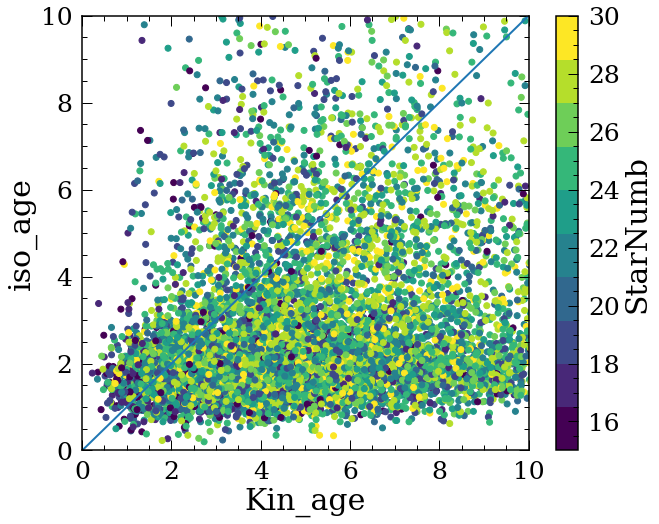

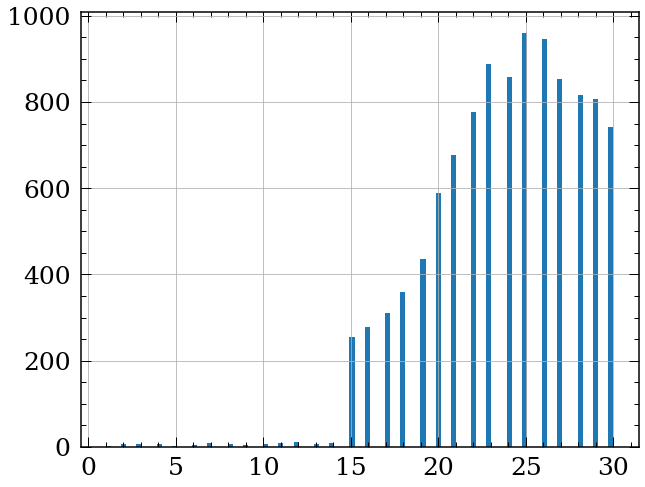

In [178]:
print('optimized bin size:',optbin,'. with chisq:',chisq)
plt.figure(figsize=(10,8))
"""
#plt.errorbar(out_comp['kin_age'],out_comp['measure_age'],yerr=out_comp['measure_age_err'],fmt='r.',alpha=0.1)
plt.plot(out_comp['kin_age'],out_comp['measure_age'],'r.',markersize=1)
"""

cm = plt.cm.get_cmap('viridis',10)
minstar=15
maxstar=30
out_comp_plot=out_comp.loc[out_comp['NumbStars']>minstar].dropna()
out_comp_plot=out_comp_plot.loc[out_comp_plot['NumbStars']<maxstar].dropna()
print(calcChi2(out_comp_plot['kin_age'],out_comp_plot['measure_age'],np.ones(len(out_comp_plot)),out_comp_plot['measure_age_err']))
plt.scatter(out_comp_plot['kin_age'],out_comp_plot['measure_age'],c=out_comp_plot['NumbStars'],cmap=cm,vmin=minstar,vmax=maxstar)
cb=plt.colorbar()
cb.set_label('StarNumb')

plt.plot([0,10],[0,10])
plt.xlabel('Kin_age')
plt.ylabel('iso_age')
plt.xlim([0,10])
plt.ylim([0,10])

plt.figure(figsize=(10,8))
out_comp['NumbStars'].hist(bins=100)

# 1.39

In [179]:

#df['vel_dis'],df['kin_age']=getkinAges(df,['teff_calc','Prot_log','abs_G'],[350.0, 0.5, 0.17])
#df['vel_dis'],df['kin_age']=getkinAges(df,['teff_calc','Prot_log','abs_G'],[200.0, 0.4, 0.5])

df_cut['vel_dis'],df_cut['kin_age']=getkinAges(df_cut,['teff_calc','Prot_log','abs_G','Ro'],
                                       [450.0, 0.05, 0.23333333333333334, 0.14444444444444446],
                                       vz='v_b',min_star=15,max_star=30)

"""\
ages=getkinAges_err(df_ruth,['color_teffs','Prot_log','abs_G','Ro'],['teff_err1','Prot_err','abs_G_err','Ro_err'],
                    [150.0, 0.23333333333333334, 0.4555555555555556, 0.14444444444444446],min_star=15,max_star=30,
                    sampsize=50,vz='all_vz',vz_err='vz_err_all')
df_ruth['kin_age_err']=[np.std(pd.Series(ages[i,:]).dropna()) for i in range(len(df_ruth))]

"""


"""
testing=10000
px_s=getErr(df['parallax'].values,df['parallax_error'].values,testing)
pmra_s=getErr(df['pmra'].values,df['pmra_error'].values,testing)
pmdec_s=getErr(df['pmdec'].values,df['pmdec_error'].values,testing)
ra_s=getErr(df['ra'].values,df['ra_error'].values,testing)
dec_s=getErr(df['dec'].values,df['dec_error'].values,testing)

"""

100%|██████████| 75493/75493 [04:10<00:00, 301.18it/s]

77452



/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in log
/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


"\ntesting=10000\npx_s=getErr(df['parallax'].values,df['parallax_error'].values,testing)\npmra_s=getErr(df['pmra'].values,df['pmra_error'].values,testing)\npmdec_s=getErr(df['pmdec'].values,df['pmdec_error'].values,testing)\nra_s=getErr(df['ra'].values,df['ra_error'].values,testing)\ndec_s=getErr(df['dec'].values,df['dec_error'].values,testing)\n\n"

In [25]:
#df_ruth['kin_age']=df_ruth['age']
#df=pd.merge(df_isoages,df,left_on='KIC',right_on='KID',how='inner')
#df.to_pickle('KinageAllKepler.pkl')
compstars(df_cut,ave=False,err=True,IOfile=False)
#plt.savefig('Figures/FinalComp_predict.png')

NameError: name 'df_cut' is not defined

In [24]:
53.4/2

26.7

In [19]:
from astropy.io import fits
with fits.open('APOGEECM_allKepler') as hdul:
    data = pd.DataFrame(hdul[1].data)


In [30]:
data=pd.read_table('KeplerRot-LAMOST.csv',delimiter=',')
list(data.columns)

['DR2Name',
 'KIC',
 'RA',
 'Dec',
 'Gmag',
 'BP_RP',
 'parallax',
 'pmra',
 'pmde',
 'rv_gaia',
 'erv_gaia',
 'Prot',
 'RV_lam',
 'e_RV_lam',
 'Teff_lam',
 'e_Teff_lam',
 'logg_lam',
 'e_logg_lam',
 'feh_lam',
 'e_feh_lam',
 'afe_lam',
 'e_afe_lam']

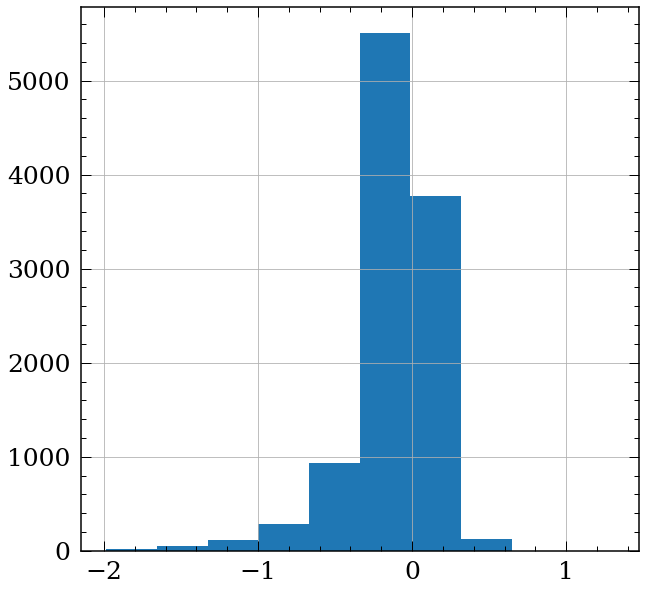

In [36]:
data['feh_lam'].hist()

In [35]:
data=data.loc[data['feh_lam']>-2]

In [42]:
sum(data['feh_lam']<-0.3)/len(data['feh_lam'])

0.1514394149773211

In [43]:
df_isoages=pd.read_table('GKSPCPapTable2.txt',delimiter='&')

In [45]:
np.median(df_isoages['iso_age_err1']/df_isoages['iso_age'])

0.5456989247311828

In [46]:
np.median(df_isoages['iso_age_err1'])

2.71